In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error # <-- IMPORTAR MÉTRICAS
# Regular packages
import pandas as pd
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsforecast.models import AutoETS
from statsforecast import StatsForecast
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy.stats import ttest_1samp
import seaborn as sns
import statsmodels.api as sm
# adds src folder to path
sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# My custom functions and classes
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from utils.calculations import process_df

# Adiciona caminhos importantes
ARRIVALS_PATH = resolve_env_path("ARRIVALS_PATH")

# Selecting seaborn theme
sns.set_theme(
    style="ticks",
    palette="bright",
    context="notebook"
)

c:\Users\Dog\Documents\Last\international_arrivals_time_series_forecasting\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
c:\Users\Dog\Documents\Last\international_arrivals_time_series_forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Carregar Banco de Dados.

In [2]:
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH)
df = arrivals_dataset.get_data_without_missing_values()

Filtrar viajens com destino ao Rio de Janeiro

In [3]:
df_rj = process_df(
    df=df,
    state="rio_de_janeiro",
    value_cols="arrivals",
    agg_func="sum",
    agg_cols="date"
)
df_rj.tail()

date  arrivals
295 2024-08-01   91504.0
296 2024-09-01  116003.0
297 2024-10-01  130985.0
298 2024-11-01  145148.0
299 2024-12-01  176121.0

Criar banco de dados para análise temporal

In [4]:
df_rj_unico = df_rj.set_index('date').copy()
data_series = df_rj_unico['arrivals']
data_series

date
2000-01-01     91318.0
2000-02-01     80424.0
2000-03-01     75716.0
2000-04-01     62957.0
2000-05-01     53855.0
                ...   
2024-08-01     91504.0
2024-09-01    116003.0
2024-10-01    130985.0
2024-11-01    145148.0
2024-12-01    176121.0
Name: arrivals, Length: 300, dtype: float64

Definir Período da covid.

In [5]:
PRE_COVID_END = '2020-02-29' # Último dia antes do impacto
COVID_START = '2020-03-01' # Primeiro dia do impacto
COVID_END = '2023-05-01'   # Último dia do período a ser imputado
dados_pre_covid = data_series.loc[:PRE_COVID_END].copy()

Projetar Componente Sazonalidade, Tendência e Combiná-los para imputar o período da covid

In [6]:
stl = STL(dados_pre_covid, period=12, seasonal=13).fit()

ultimo_ano_sazonal = stl.seasonal[-12:]
indice_gap_covid = data_series.loc[COVID_START:COVID_END].index
n_meses_gap = len(indice_gap_covid)

n_repeticoes = int(np.ceil(n_meses_gap / 12))
valores_sazonais_projetados = np.tile(ultimo_ano_sazonal.values, n_repeticoes)[:n_meses_gap]

sazonal_imputado = pd.Series(valores_sazonais_projetados, index=indice_gap_covid)


segmento_tendencia_recente = stl.trend.dropna().iloc[-12:]

x = np.arange(len(segmento_tendencia_recente))
y = segmento_tendencia_recente.values
coefs = np.polyfit(x, y, 1) # Retorna [slope, intercept]
slope = coefs[0]

ultimo_valor_tendencia = segmento_tendencia_recente.iloc[-1]
x_projecao = np.arange(1, n_meses_gap + 1)
valores_tendencia_projetados = (slope * x_projecao) + ultimo_valor_tendencia

tendencia_imputada = pd.Series(valores_tendencia_projetados, index=indice_gap_covid)


valores_imputados = tendencia_imputada + sazonal_imputado
data_series_imputada = data_series.copy()
data_series_imputada.loc[COVID_START:COVID_END] = valores_imputados
data_series_imputada

date
2000-01-01     91318.0
2000-02-01     80424.0
2000-03-01     75716.0
2000-04-01     62957.0
2000-05-01     53855.0
                ...   
2024-08-01     91504.0
2024-09-01    116003.0
2024-10-01    130985.0
2024-11-01    145148.0
2024-12-01    176121.0
Name: arrivals, Length: 300, dtype: float64

Plot da Comparação da Imputação com o Período Original.

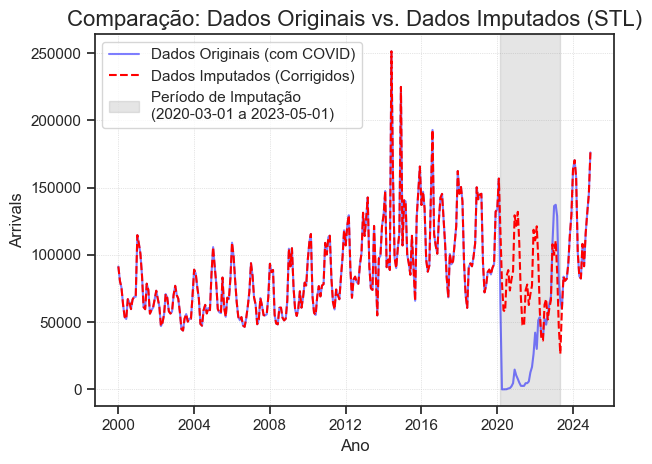

In [7]:
plt.plot(data_series.index, data_series, label='Dados Originais (com COVID)', 
         color='blue', alpha=0.5)

# Plota os novos dados imputados
plt.plot(data_series_imputada.index, data_series_imputada, 
         label='Dados Imputados (Corrigidos)', 
         color='red', linestyle='--')

# Destaca a área que foi imputada
plt.axvspan(pd.to_datetime(COVID_START), pd.to_datetime(COVID_END), 
            color='gray', alpha=0.2, label=f'Período de Imputação\n({COVID_START} a {COVID_END})')

plt.title('Comparação: Dados Originais vs. Dados Imputados (STL)', fontsize=16)
plt.ylabel(data_series.name.capitalize() if data_series.name else 'Valores')
plt.xlabel('Ano')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

ETS Python

In [8]:
# Treino até 2023-12-31 e teste em 2024, treino ETS via AutoETS (statsforecast) e previsão


train_end = '2023-12-31'
test_start = '2024-01-01'
test_end = '2024-12-31'

# Série de treino e teste a partir da série já imputada
train_series = data_series_imputada.loc[:train_end].copy()
test_series = data_series_imputada.loc[test_start:test_end].copy()

# Prepara DataFrame no formato esperado pelo StatsForecast (unique_id, ds, y)
df_sf = pd.DataFrame({
    'unique_id': 'rj',
    'ds': train_series.index,
    'y': train_series.values
})

# Inicializa o objeto StatsForecast com AutoETS
sf = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)

sf.fit(df=df_sf)

# Chamada correta: passar o DataFrame como argumento para forecast()
forecasts = sf.forecast(df=df_sf, h=12, level=[80,95], fitted=True)

# Identifica a coluna de previsão (pode variar de nome conforme versão)
pred_col = [c for c in forecasts.columns if c not in ('unique_id', 'ds')][0]

# Series de previsão alinhada com as datas do horizonte
pred_index = pd.to_datetime(forecasts['ds'])
y_pred_teste = forecasts[pred_col].values

# Valores s (verdadeiros) para 2024 alinhados com o índice de previsão
y_true_teste = test_series.reindex(pred_index).values

# Métricas
rmse_val = np.sqrt(mean_squared_error(y_true_teste, y_pred_teste))
mape_val = mean_absolute_percentage_error(y_true_teste, y_pred_teste) * 100
mae_val = mean_absolute_error(y_true_teste, y_pred_teste)

# Extrai as previsões in-sample (ajuste no treino)
fitted_values_df = sf.forecast_fitted_values()

# Alinha os valores verdadeiros do treino com as previsões
y_true_treino = df_sf['y'].values
y_pred_treino = fitted_values_df['AutoETS'].values

# Métricas para o período de treino
rmse_treino = np.sqrt(mean_squared_error(y_true_treino, y_pred_treino))
mape_treino = mean_absolute_percentage_error(y_true_treino, y_pred_treino) * 100
mae_treino = mean_absolute_error(y_true_treino, y_pred_treino)

print(f"RMSE (Treino): {rmse_treino:.2f}")
print(f"MAPE (Treino): {mape_treino:.2f}%")
print(f"MAE (Treino): {mae_treino:.2f}")

print(f"\nRMSE (2024): {rmse_val:.2f}")
print(f"MAPE (2024): {mape_val:.2f}%")
print(f"MAE (2024): {mae_val:.2f}")

# Plot
plt.figure(figsize=(14, 7))

# Plot da série completa imputada
plt.plot(data_series_imputada.index, data_series_imputada.values, 
         label='Série Imputada Completa', color='gray', alpha=0.6)

# Plot dos valores ajustados no treino
plt.plot(fitted_values_df['ds'], y_pred_treino, 
         label=f'Ajuste no Treino (MAPE: {mape_treino:.2f}%)', color='orange')

# Plot da previsão para o período de teste
plt.plot(pred_index, y_pred_teste, 
         label=f'Previsão 2024 (MAPE: {mape_val:.2f}%)', color='red', linestyle='--')

# Intervalos de confiança
plt.fill_between(pred_index, forecasts['AutoETS-lo-95'], forecasts['AutoETS-hi-95'], 
                 color='red', alpha=0.1, label='Intervalo de Confiança 95%')
plt.fill_between(pred_index, forecasts['AutoETS-lo-80'], forecasts['AutoETS-hi-80'], 
                 color='red', alpha=0.2, label='Intervalo de Confiança 80%')

plt.title('Ajuste no Treino e Previsão com AutoETS', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Chegadas')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()


RMSE (Treino): 17891.70
MAPE (Treino): 13.37%
MAE (Treino): 11492.44

RMSE (2024): 37456.85
MAPE (2024): 23.50%
MAE (2024): 32431.37


Análise dos resíduos

--- Análise de Resíduos (Conjunto de Treino) ---

1. Teste T para Média Zero:
   Estatística t: 0.9943
   p-valor: 0.3209
   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero (p > 0.05).

2. Teste de Ljung-Box (Autocorrelação, lag=24):
   p-valor: 0.0007
   ✗ FALHA: Autocorrelação significativa detectada nos resíduos (p < 0.05).

3. Teste de Jarque-Bera (Normalidade):
   Estatística: 5550.7204
   p-valor: 0.0000
   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos (p < 0.05).

4. Teste ARCH (Heterocedasticidade, lags=12):
   p-valor: 0.1386
   ✓ PASSA: Não há evidência de heterocedasticidade (p > 0.05).


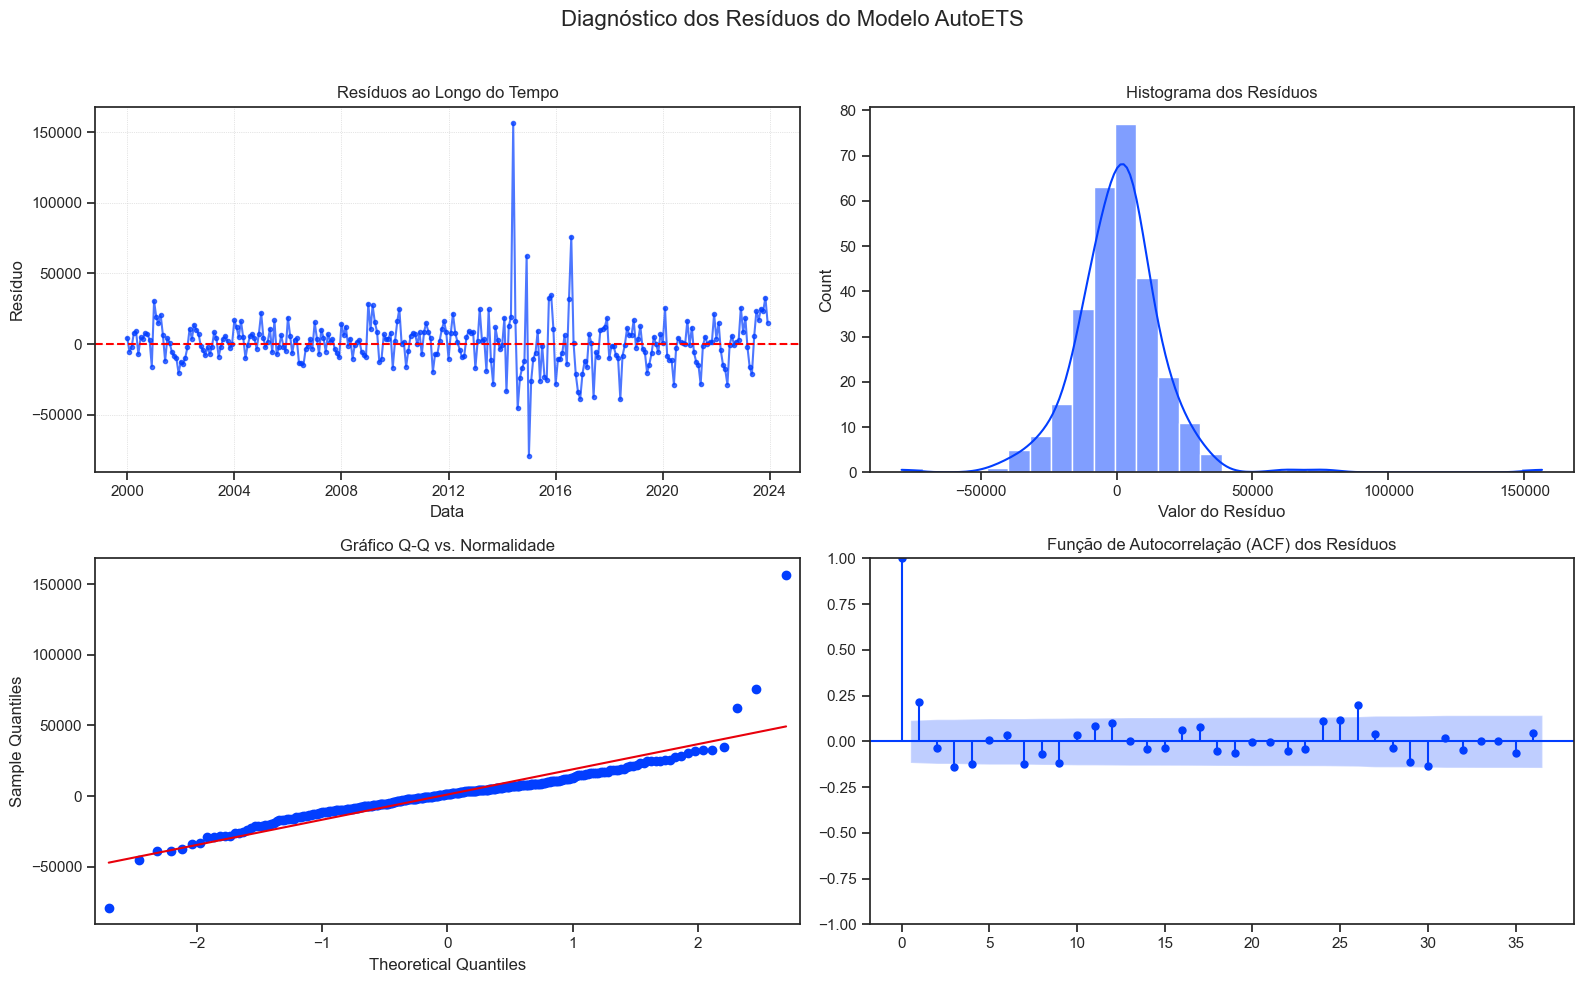

In [9]:
# Calculate residuals from the training period
residuals_train = y_true_treino - y_pred_treino

# --- Residual Diagnostics (Training Set) ---
print("--- Análise de Resíduos (Conjunto de Treino) ---")

# Import necessary libraries for diagnostics

# 1. Teste T para Média Zero
print("\n1. Teste T para Média Zero:")
if len(residuals_train) > 1:
    t_stat, t_pvalue = ttest_1samp(residuals_train, 0)
    print(f"   Estatística t: {t_stat:.4f}")
    print(f"   p-valor: {t_pvalue:.4f}")
    if t_pvalue > 0.05:
        print("   ✓ PASSA: A média dos resíduos não é significativamente diferente de zero (p > 0.05).")
    else:
        print("   ✗ FALHA: A média dos resíduos é significativamente diferente de zero (p < 0.05).")
        if residuals_train.mean() > 0:
            print("   → O modelo tende a SUBESTIMAR os valores reais.")
        else:
            print("   → O modelo tende a SUPERESTIMAR os valores reais.")
else:
    print("   Não foi possível realizar o Teste T (dados insuficientes).")


# 2. Teste de Ljung-Box para Autocorrelação
print("\n2. Teste de Ljung-Box (Autocorrelação, lag=24):")
if len(residuals_train) > 24:
    lb_test = acorr_ljungbox(residuals_train, lags=[24], return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[0]
    print(f"   p-valor: {lb_pvalue:.4f}")
    if lb_pvalue > 0.05:
        print("   ✓ PASSA: Não há evidência de autocorrelação nos resíduos (p > 0.05).")
    else:
        print("   ✗ FALHA: Autocorrelação significativa detectada nos resíduos (p < 0.05).")
else:
    print("   Não foi possível realizar o Teste de Ljung-Box (dados insuficientes).")

# 3. Teste de Jarque-Bera para Normalidade
print("\n3. Teste de Jarque-Bera (Normalidade):")
if len(residuals_train) > 1:
    jb_stat, jb_pvalue = stats.jarque_bera(residuals_train)
    print(f"   Estatística: {jb_stat:.4f}")
    print(f"   p-valor: {jb_pvalue:.4f}")
    if jb_pvalue > 0.05:
        print("   ✓ PASSA: Os resíduos parecem ser normalmente distribuídos (p > 0.05).")
    else:
        print("   ✗ FALHA: Os resíduos não parecem ser normalmente distribuídos (p < 0.05).")
else:
    print("   Não foi possível realizar o Teste de Jarque-Bera (dados insuficientes).")

# 4. Teste ARCH para Heterocedasticidade
print("\n4. Teste ARCH (Heterocedasticidade, lags=12):")
try:
    arch_test = het_arch(residuals_train, nlags=12)
    arch_pvalue = arch_test[1]
    print(f"   p-valor: {arch_pvalue:.4f}")
    if arch_pvalue > 0.05:
        print("   ✓ PASSA: Não há evidência de heterocedasticidade (p > 0.05).")
    else:
        print("   ✗ FALHA: Heterocedasticidade detectada (p < 0.05).")
except Exception as e:
    print(f"   Não foi possível realizar o Teste ARCH: {e}")


# --- Plots de Diagnóstico ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Diagnóstico dos Resíduos do Modelo AutoETS', fontsize=16)

# Plot 1: Resíduos ao longo do tempo
axes[0, 0].plot(train_series.index, residuals_train, marker='o', linestyle='-', markersize=3, alpha=0.7)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title('Resíduos ao Longo do Tempo')
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Resíduo')
axes[0, 0].grid(True, which='both', linestyle=':', linewidth=0.5)

# Plot 2: Histograma dos resíduos
sns.histplot(residuals_train, kde=True, ax=axes[0, 1], bins=30)
axes[0, 1].set_title('Histograma dos Resíduos')
axes[0, 1].set_xlabel('Valor do Resíduo')

# Plot 3: Gráfico Q-Q (Quantil-Quantil)
sm.qqplot(residuals_train, line='s', ax=axes[1, 0])
axes[1, 0].set_title('Gráfico Q-Q vs. Normalidade')

# Plot 4: Gráfico de Autocorrelação (ACF)
sm.graphics.tsa.plot_acf(residuals_train, ax=axes[1, 1], lags=36)
axes[1, 1].set_title('Função de Autocorrelação (ACF) dos Resíduos')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


--- Comparativo de Todos os Modelos ETS ++ Análise de Resíduos ---


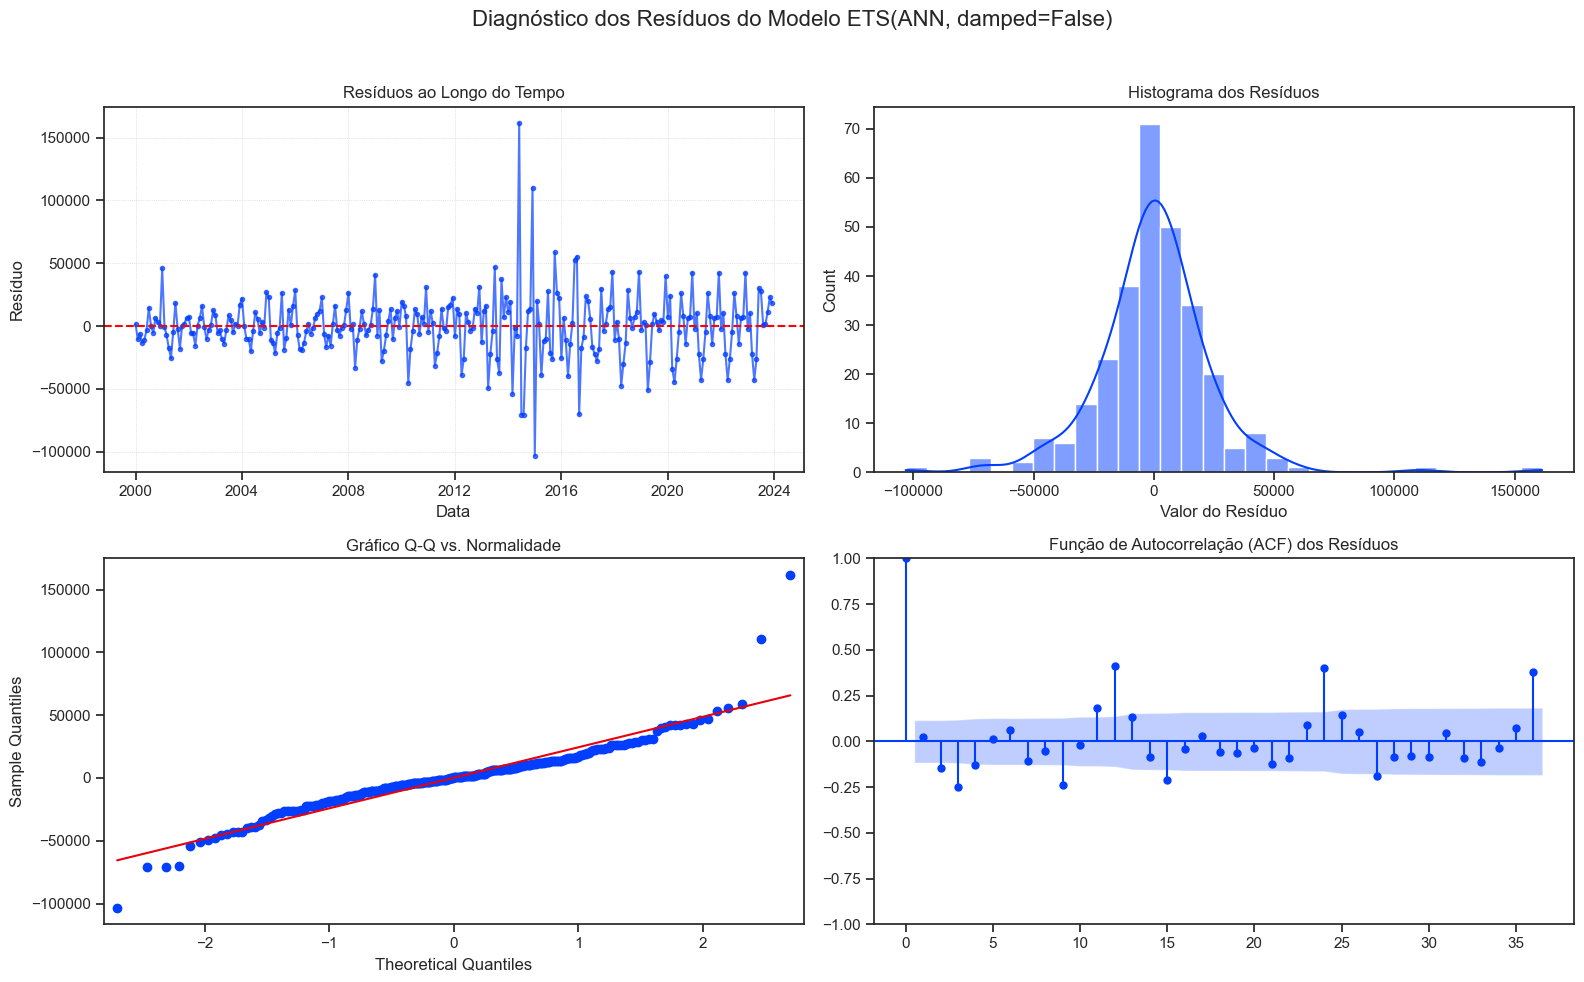

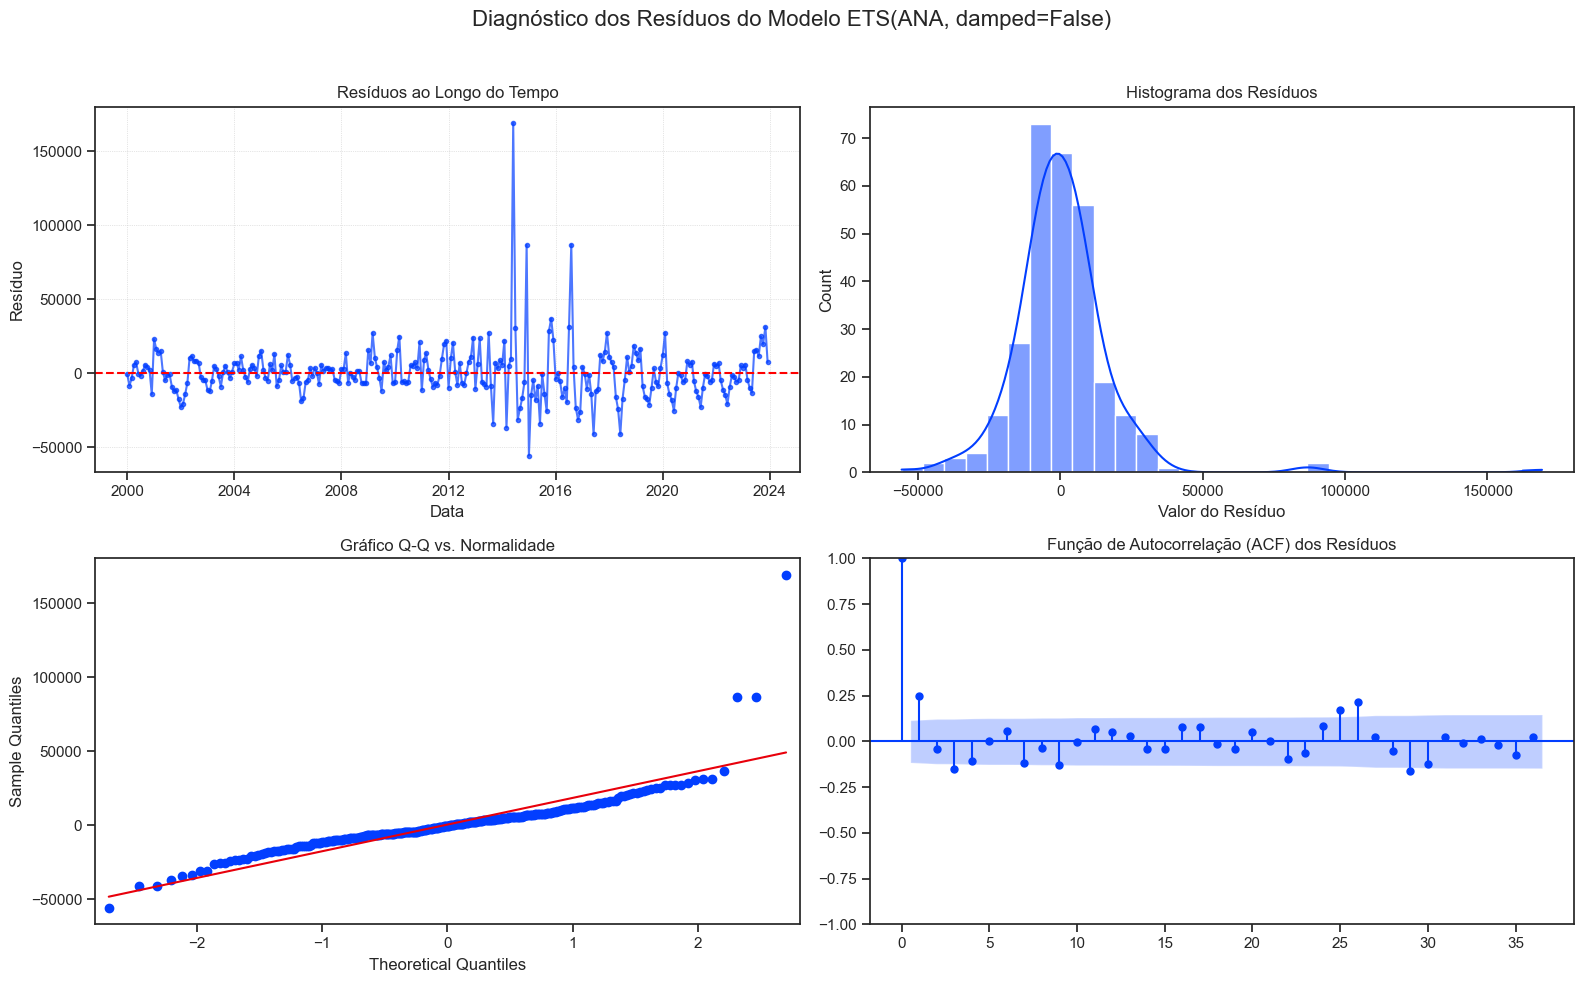

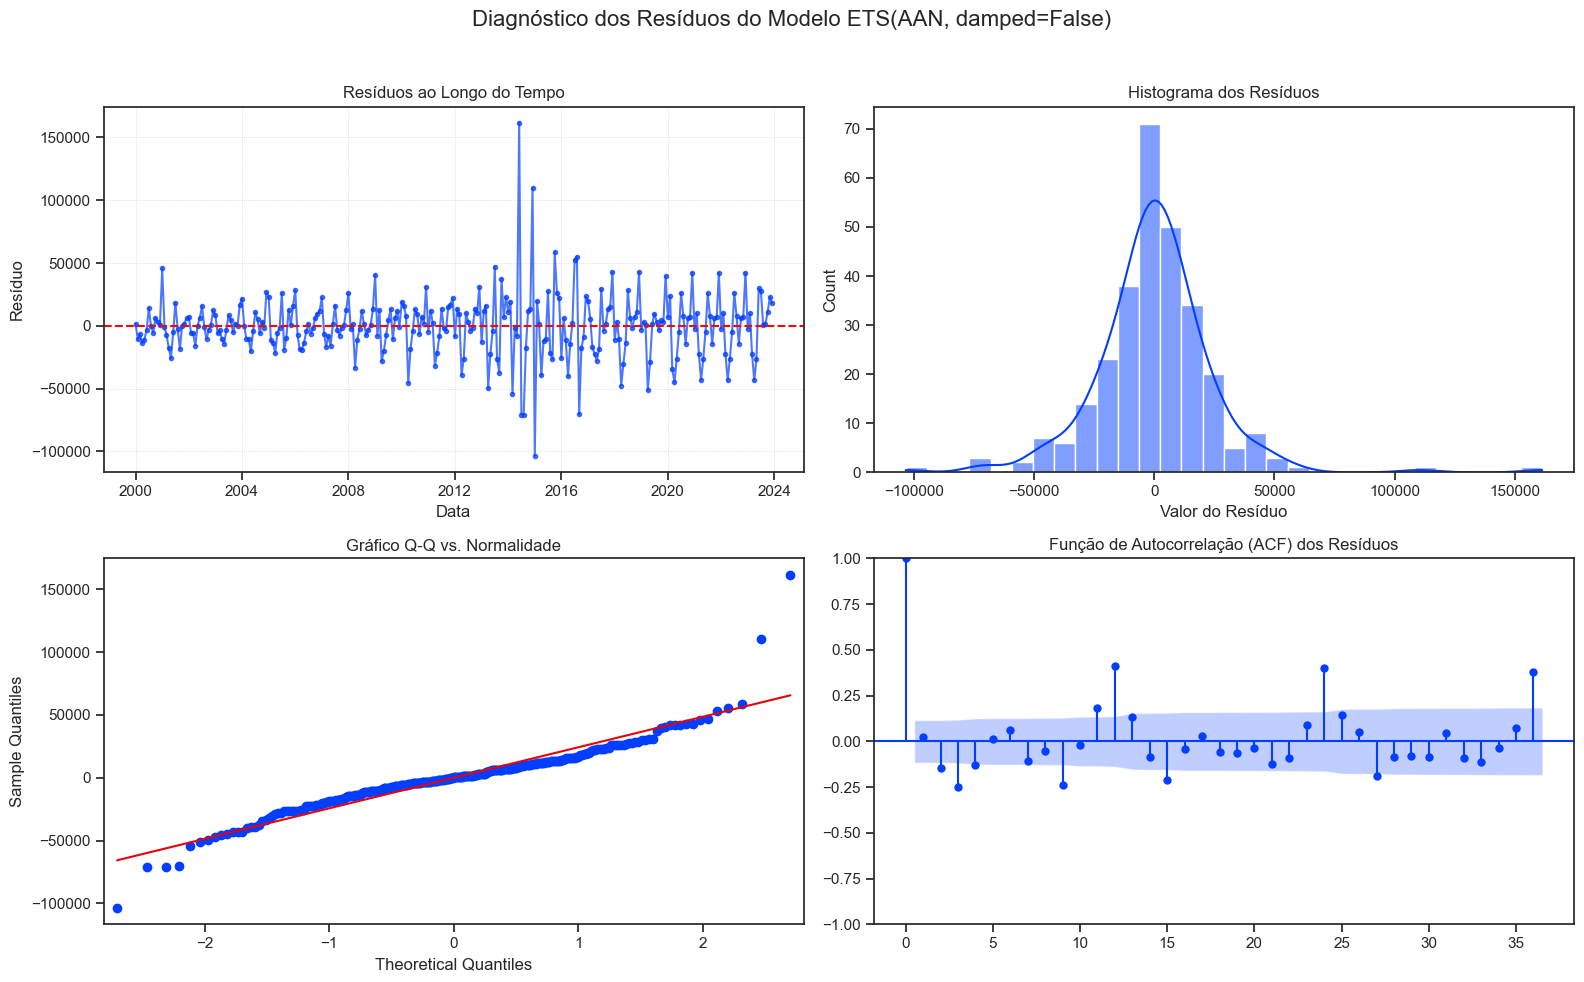

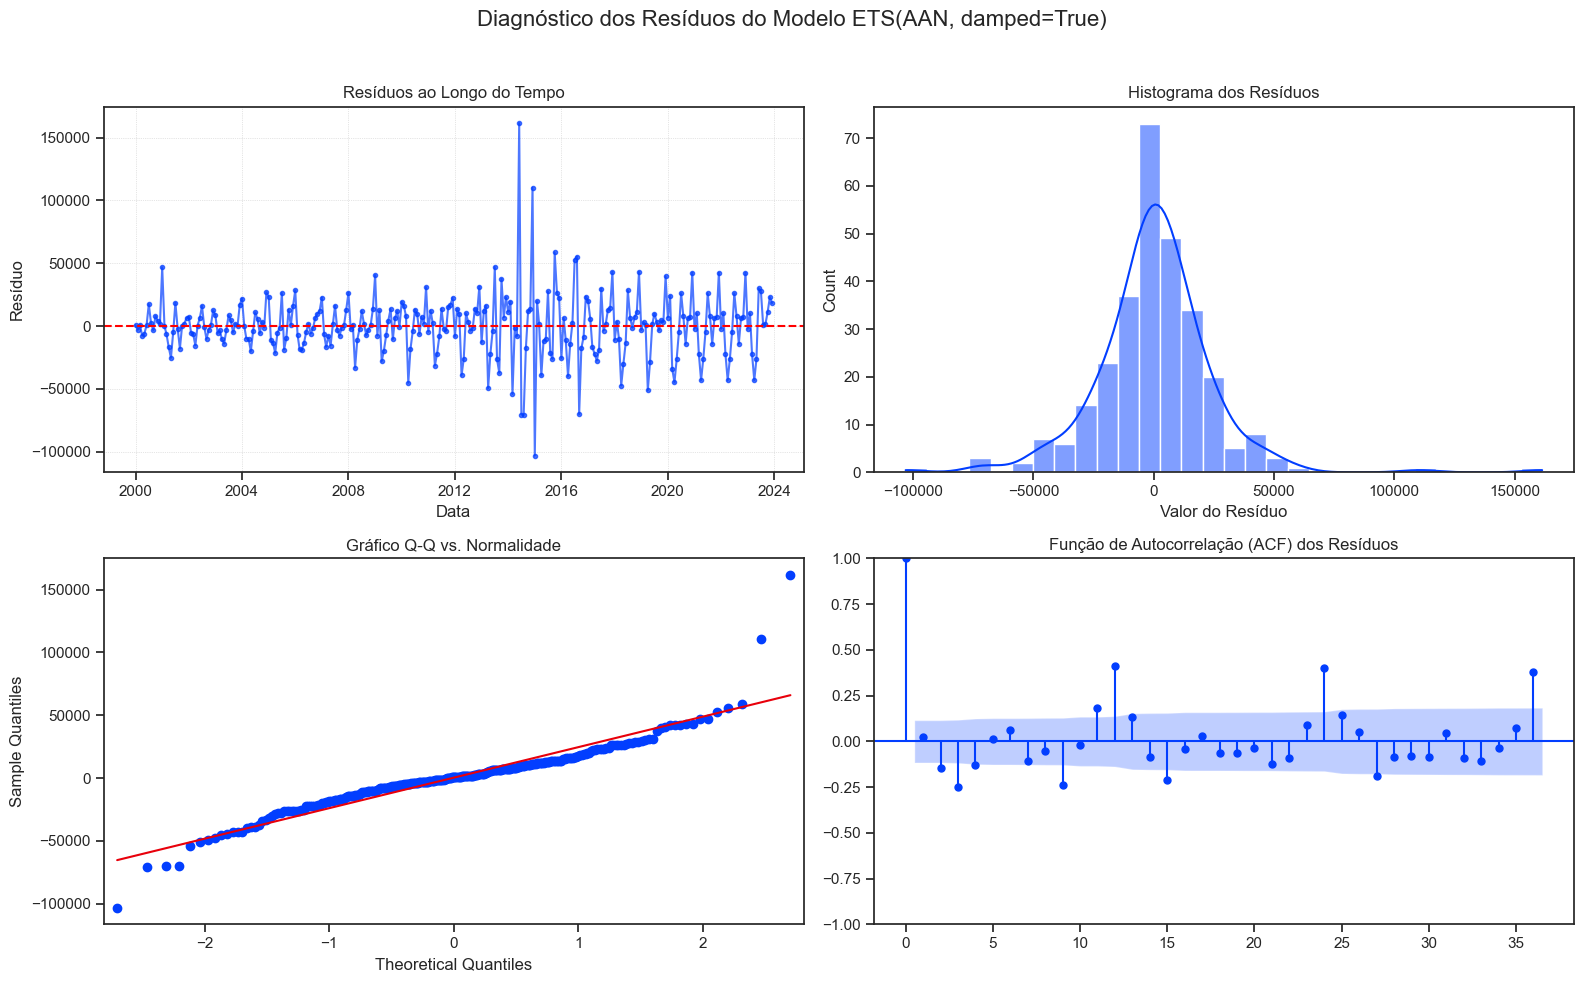

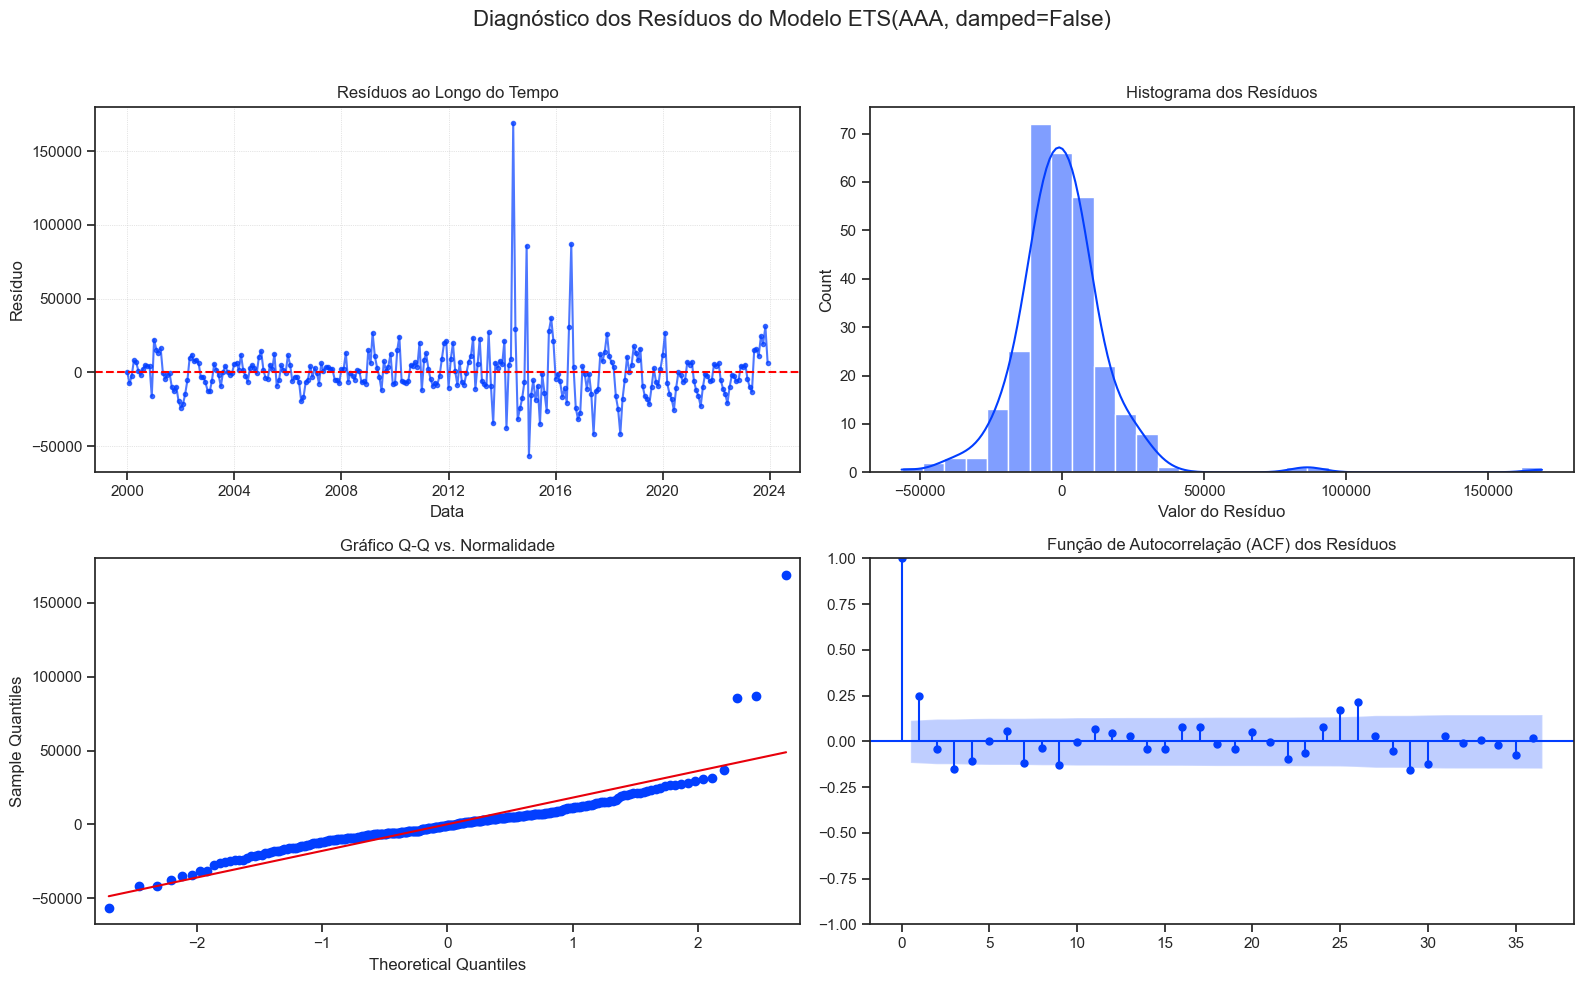

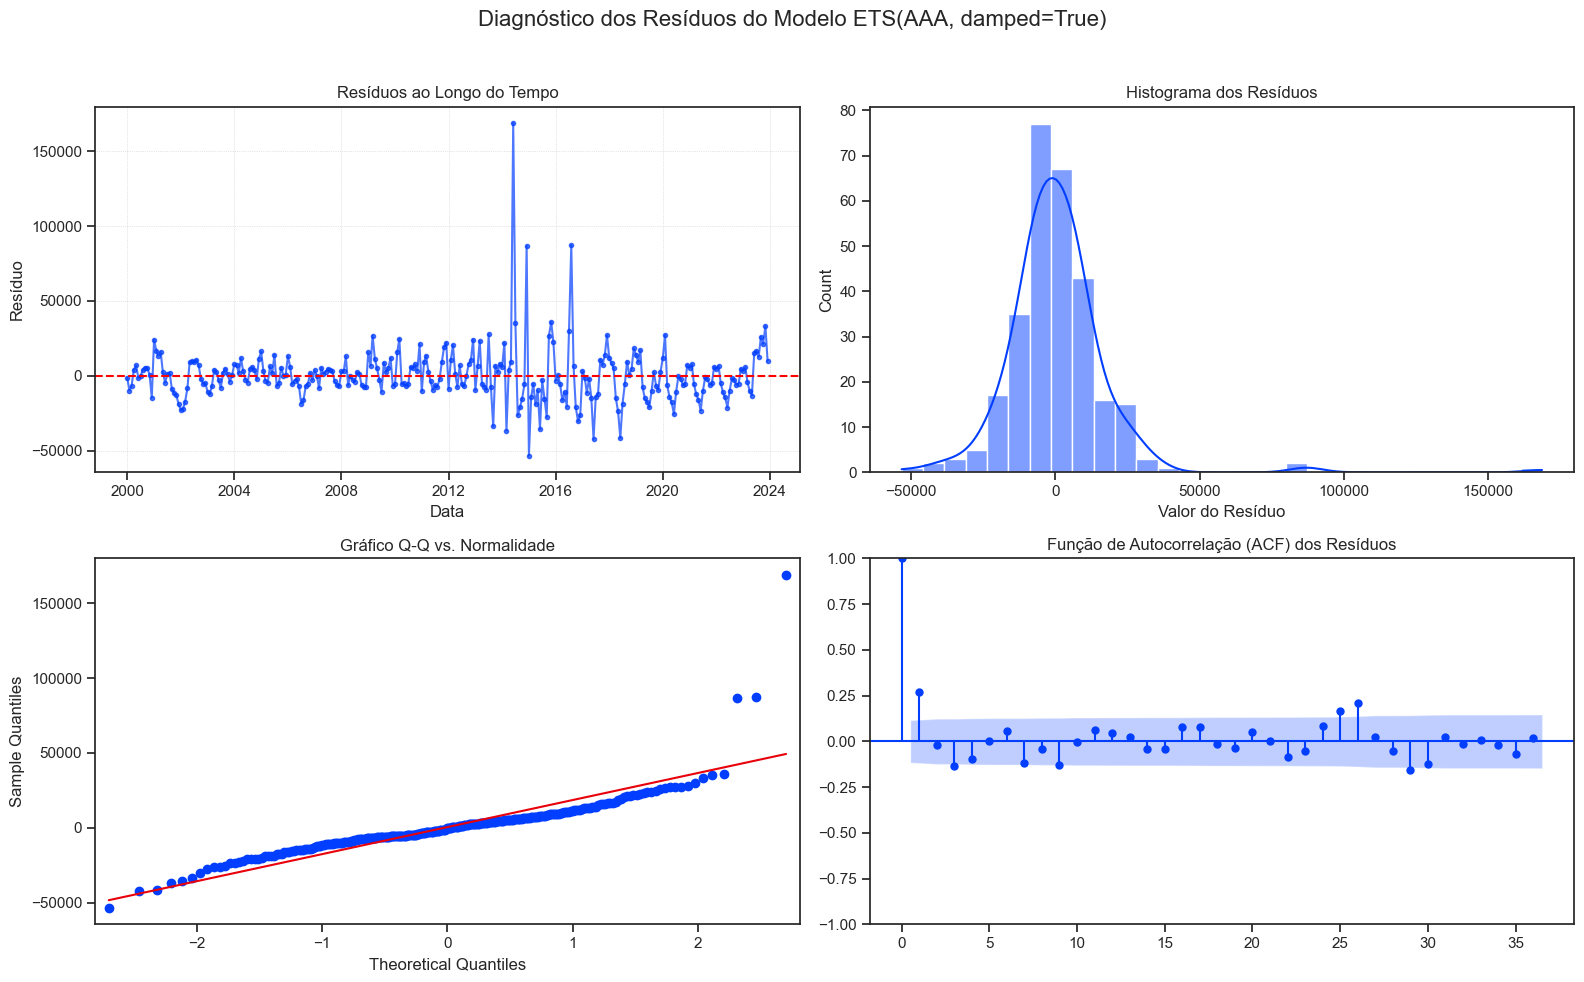

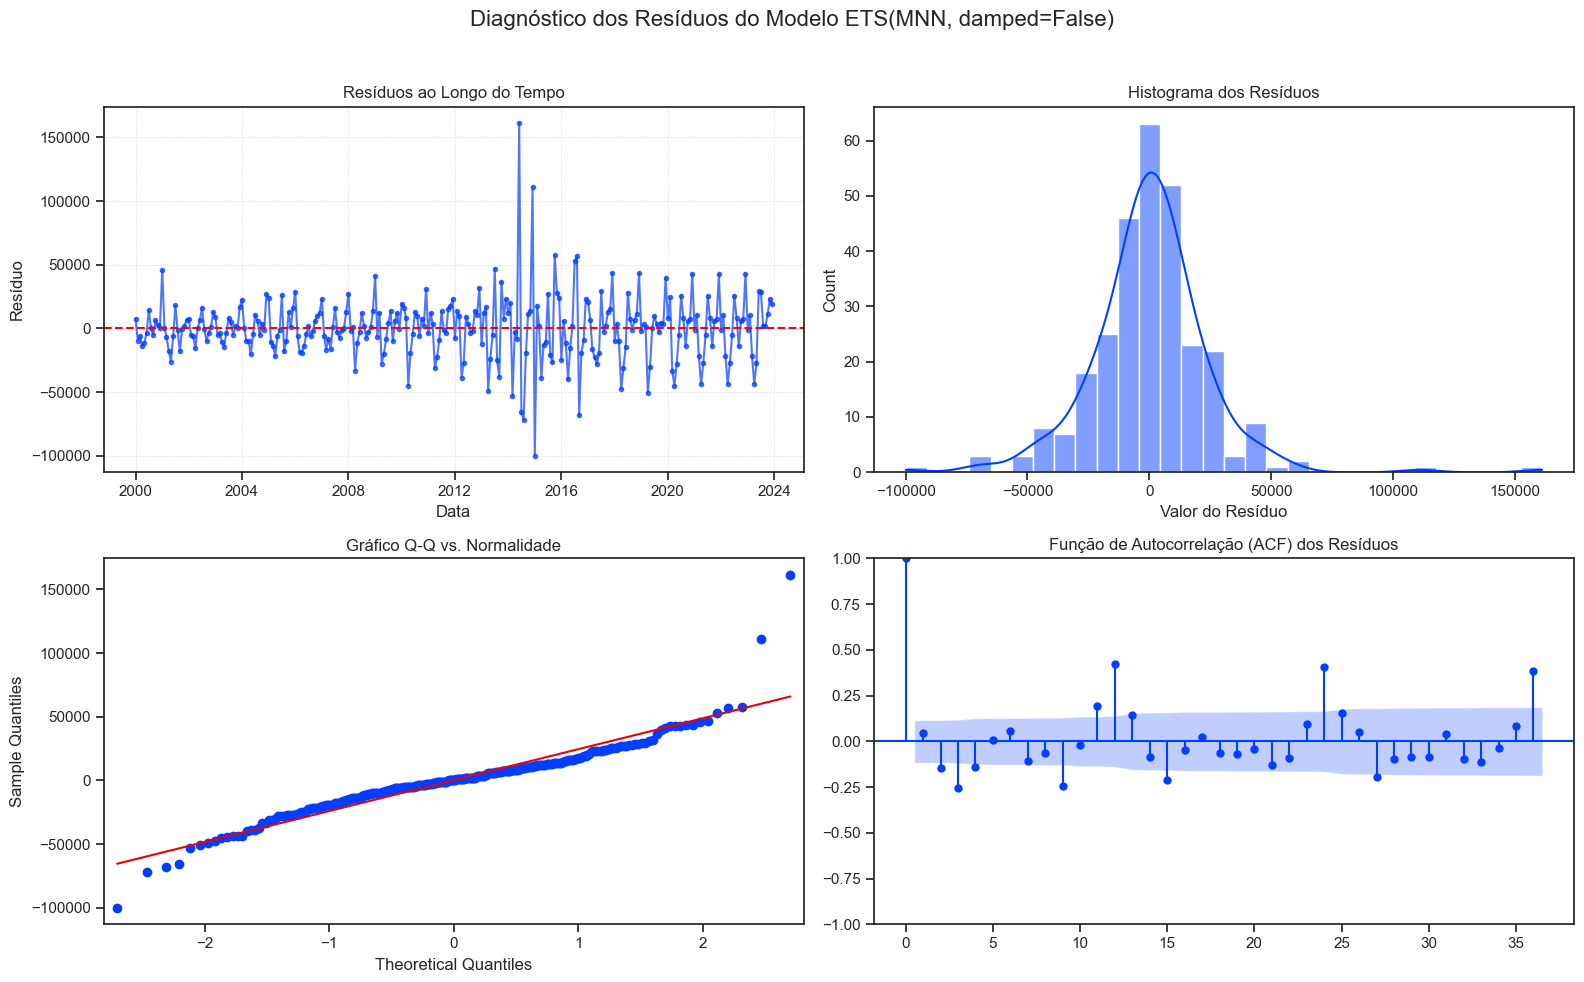

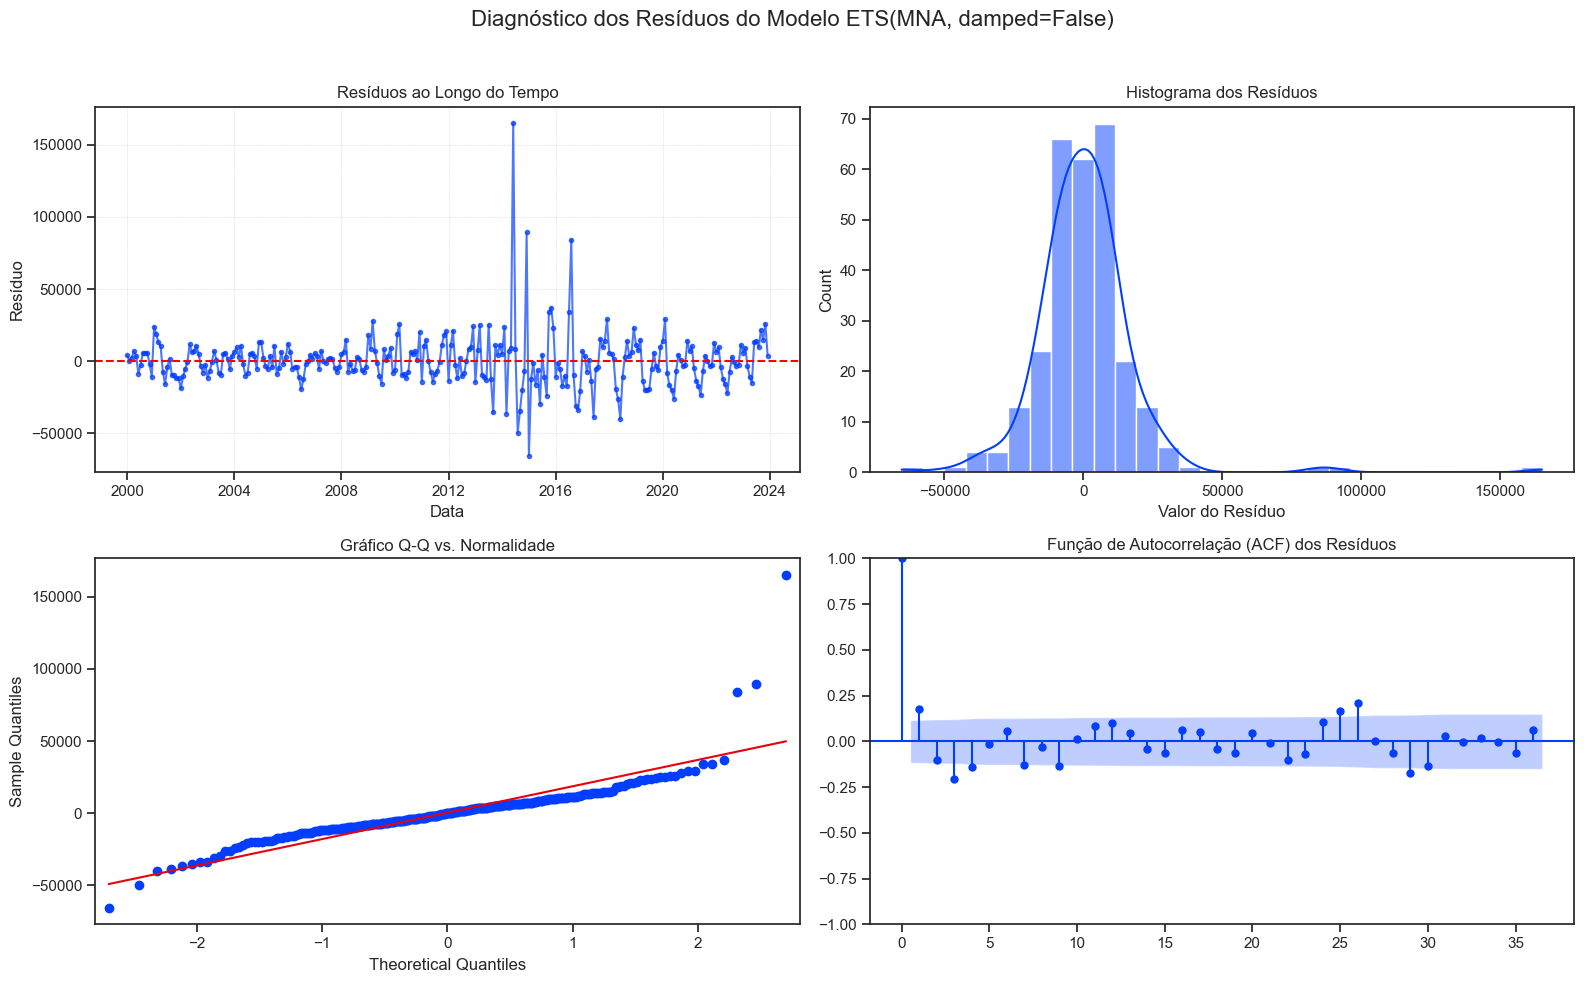

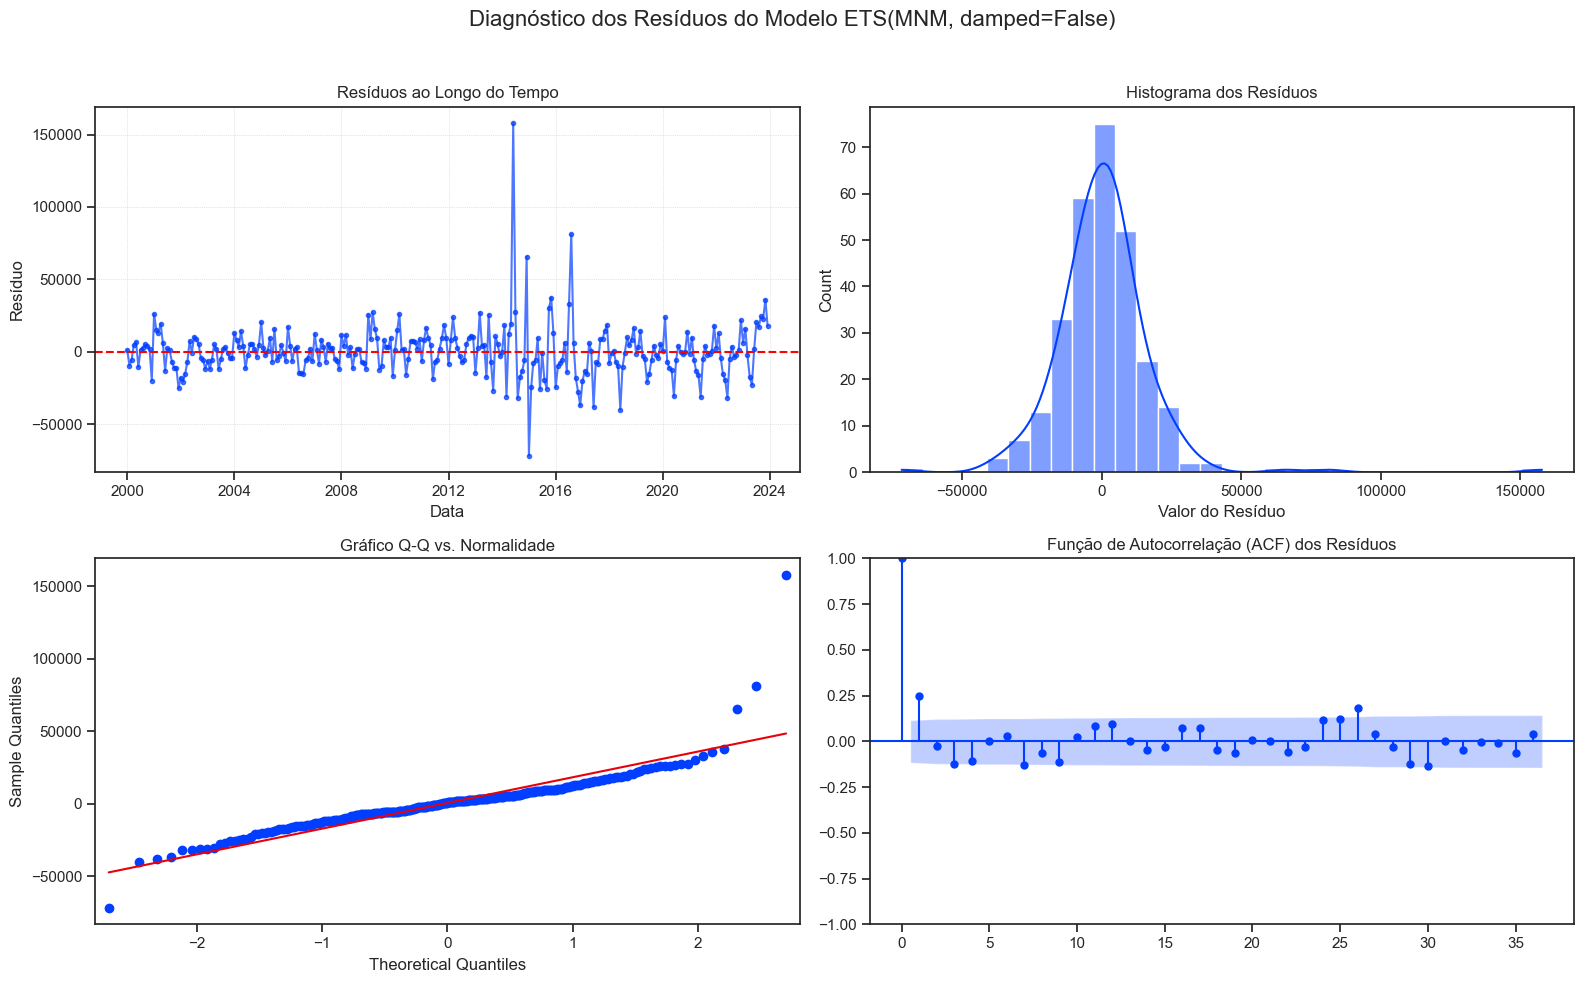

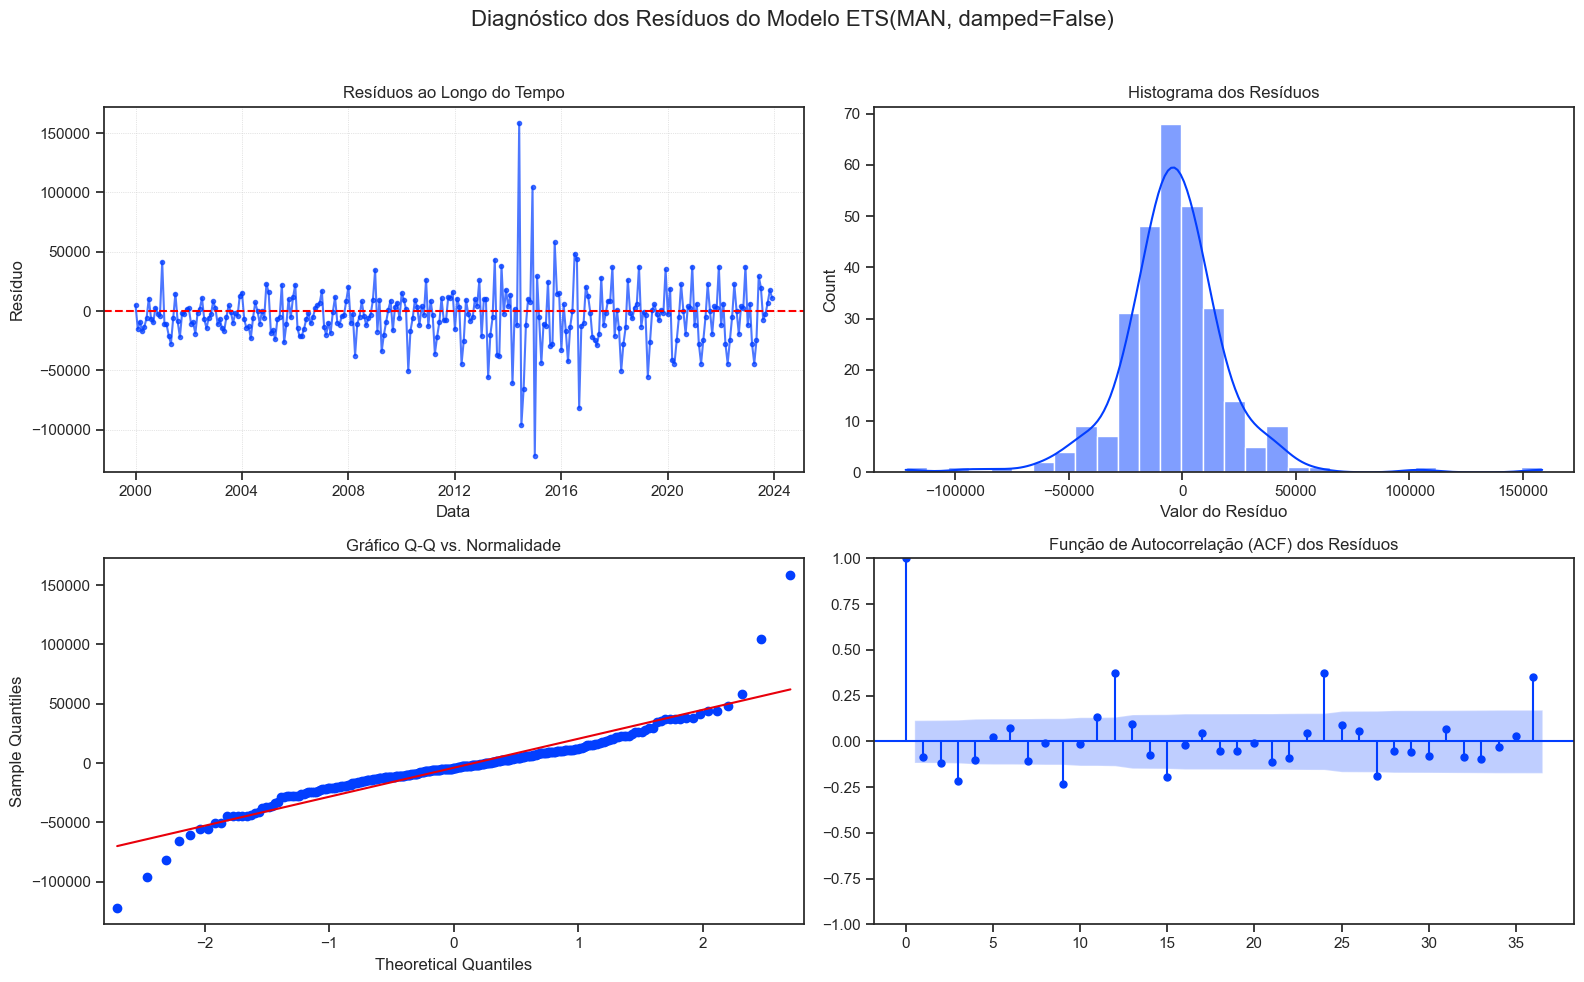

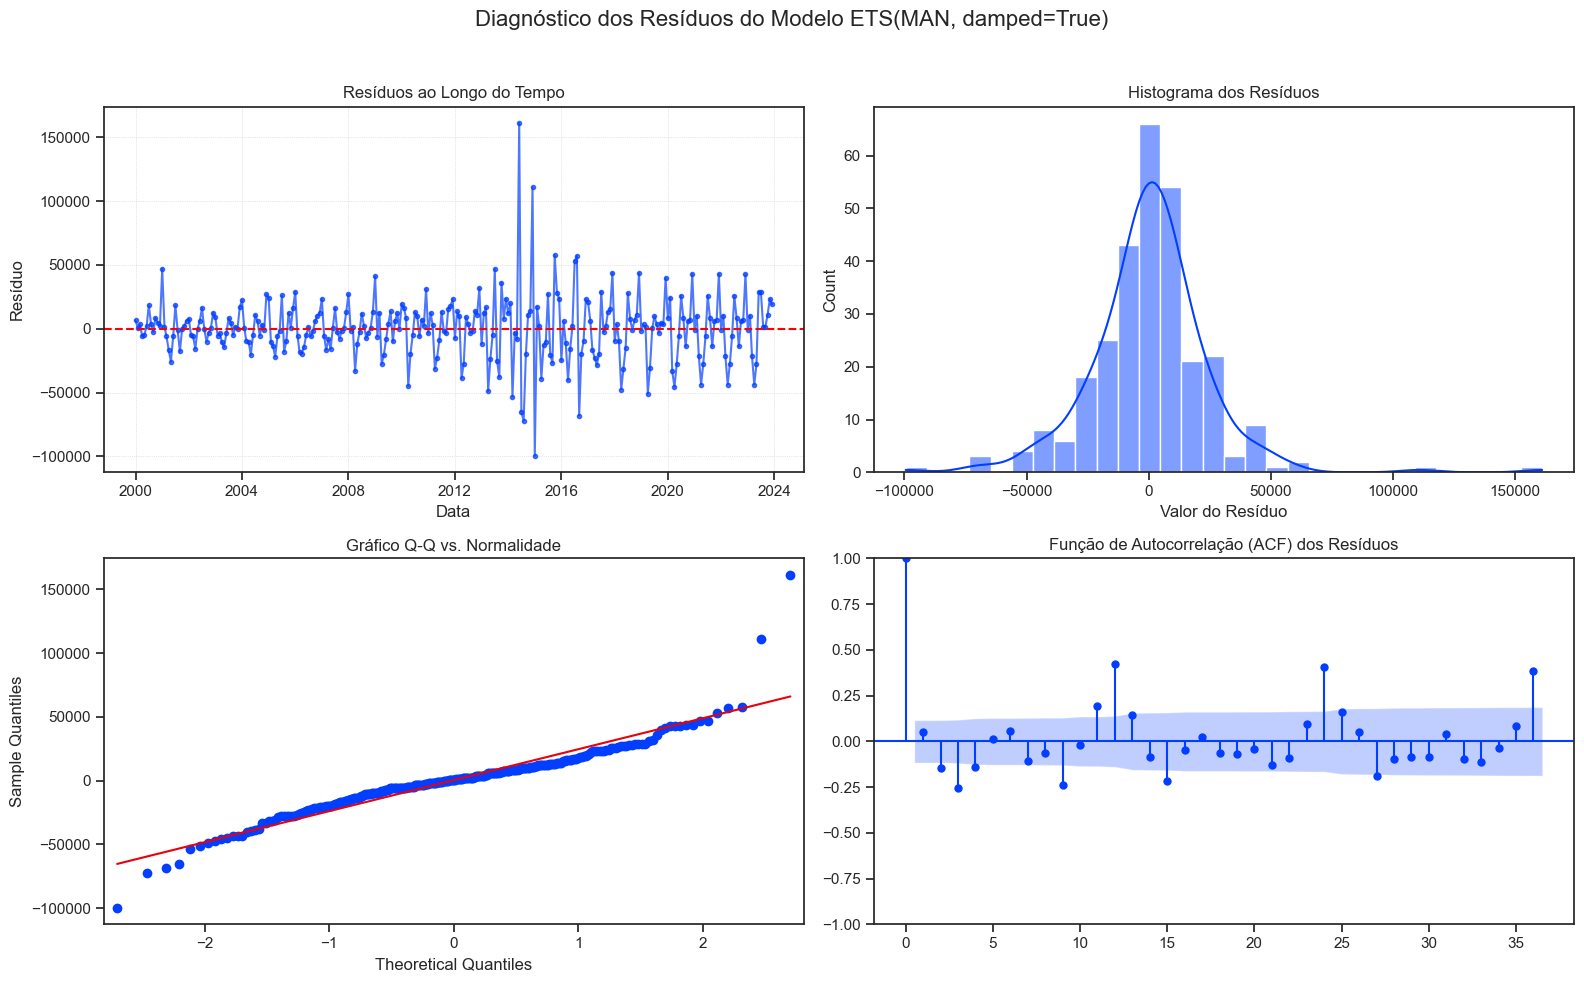

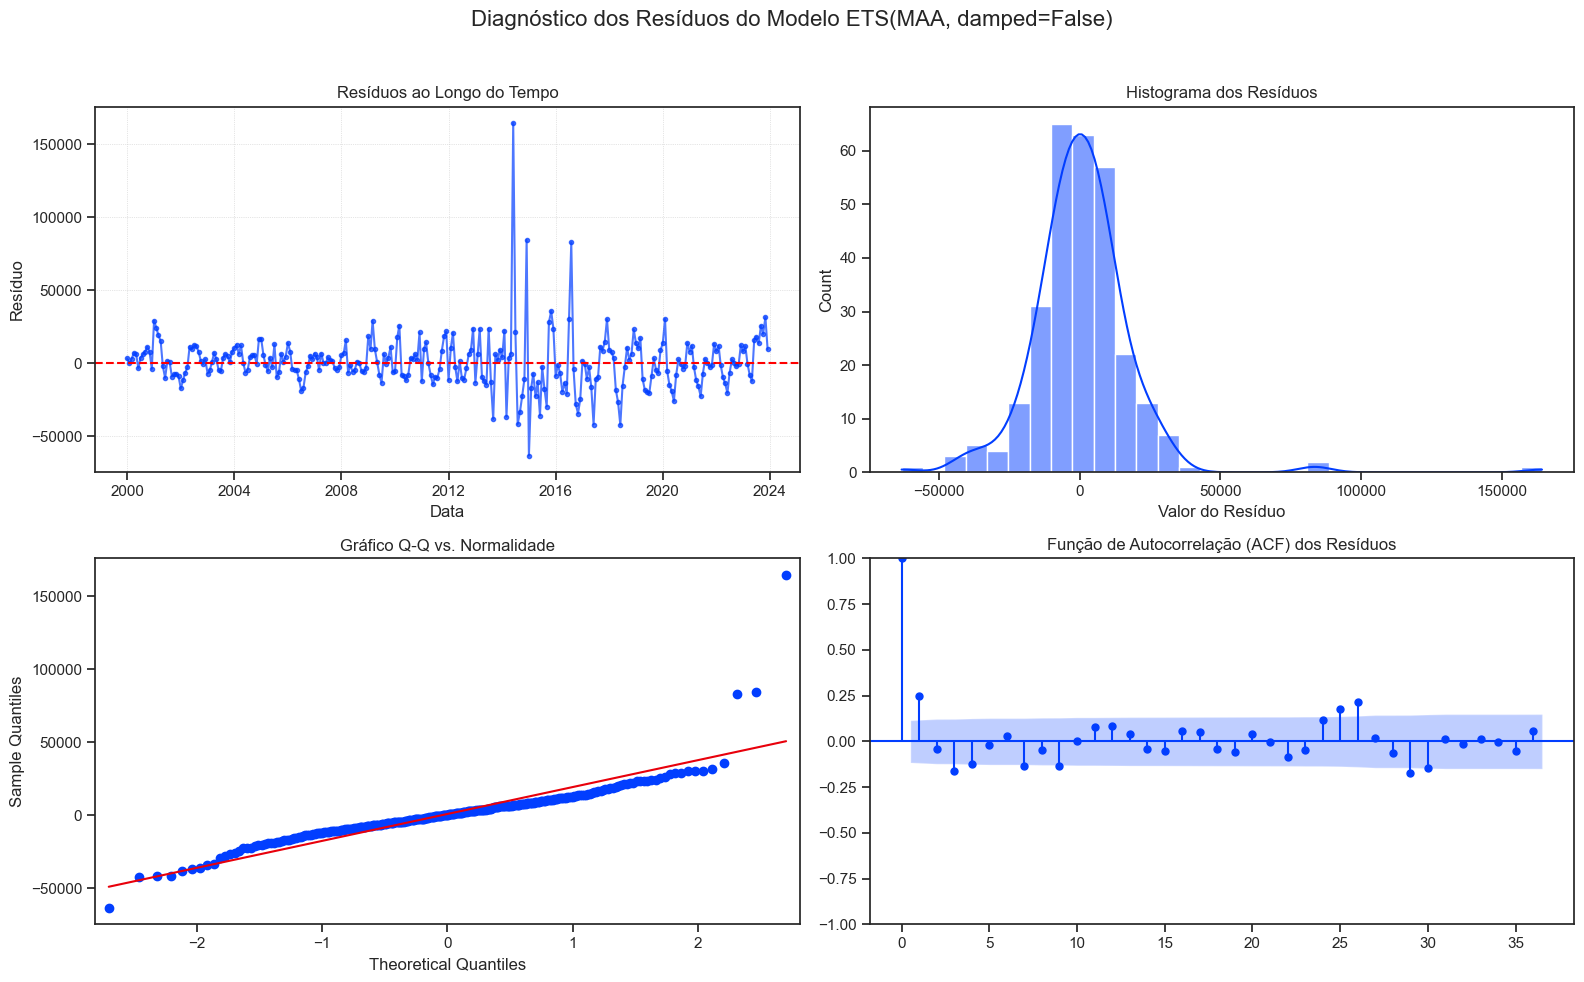

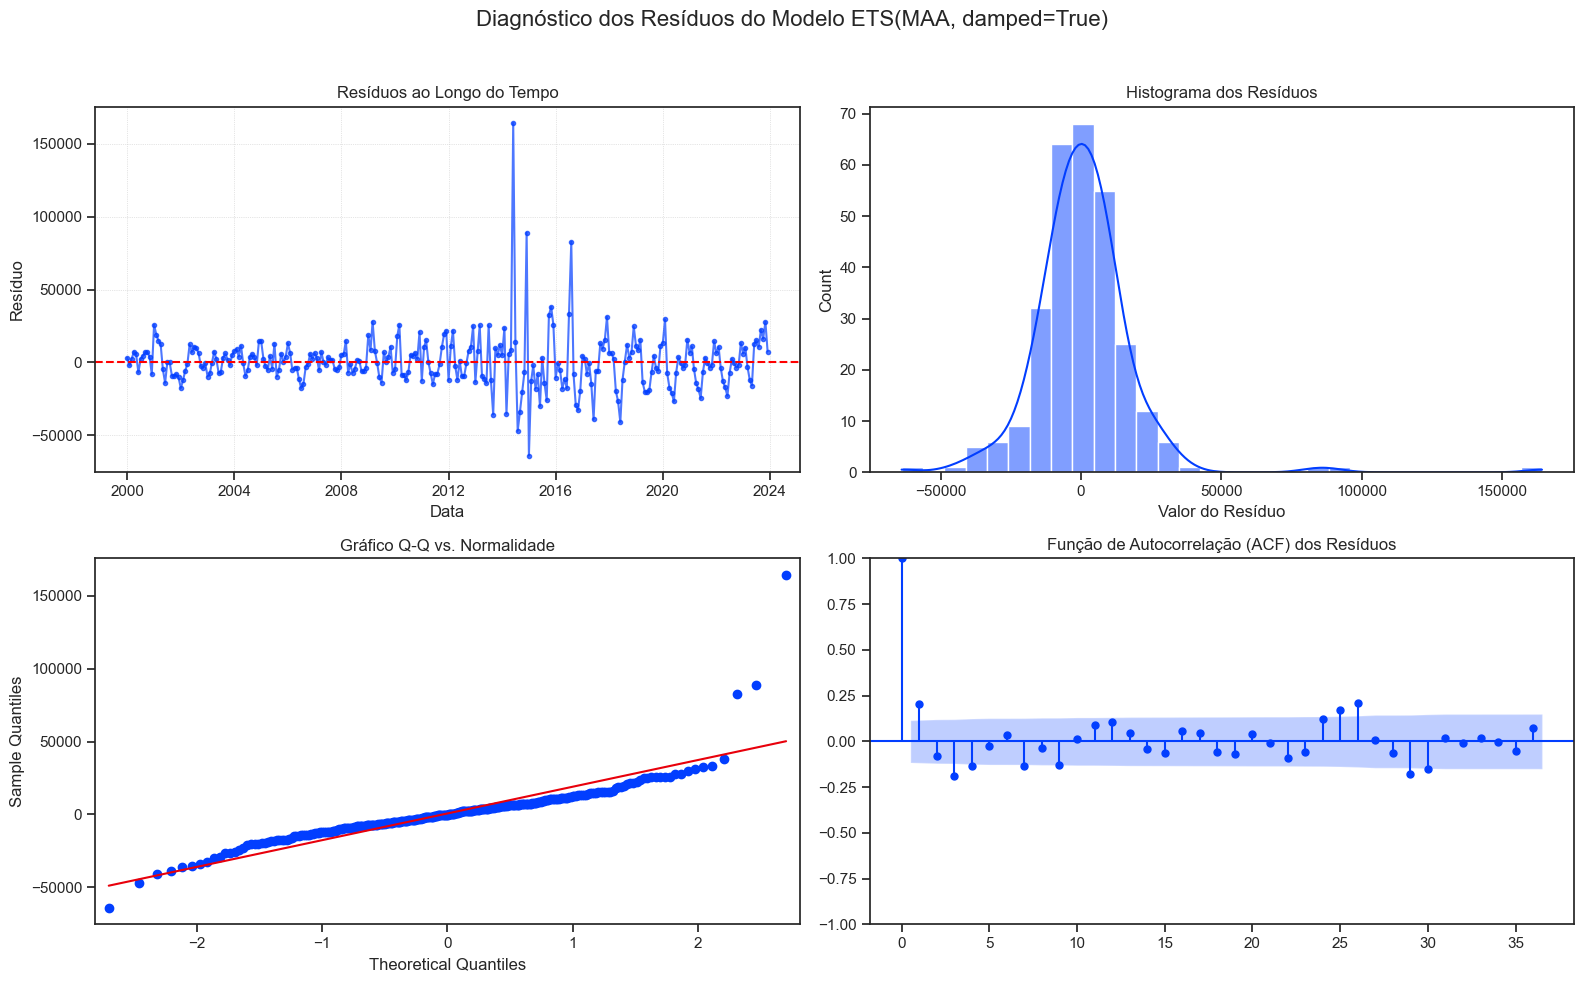

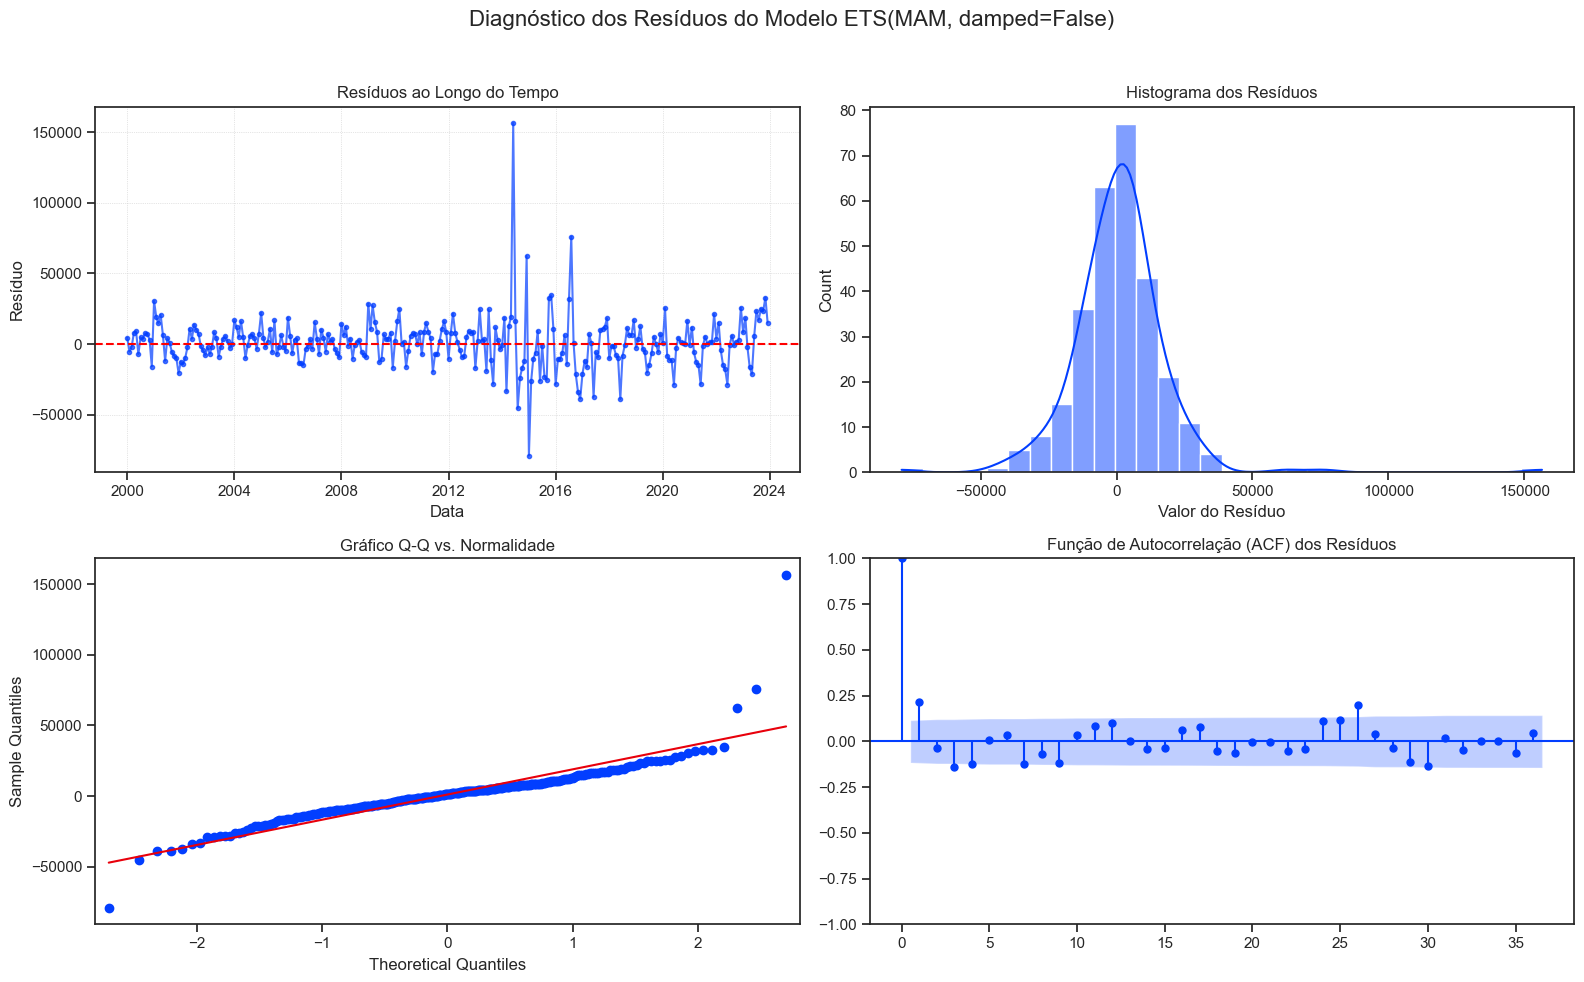

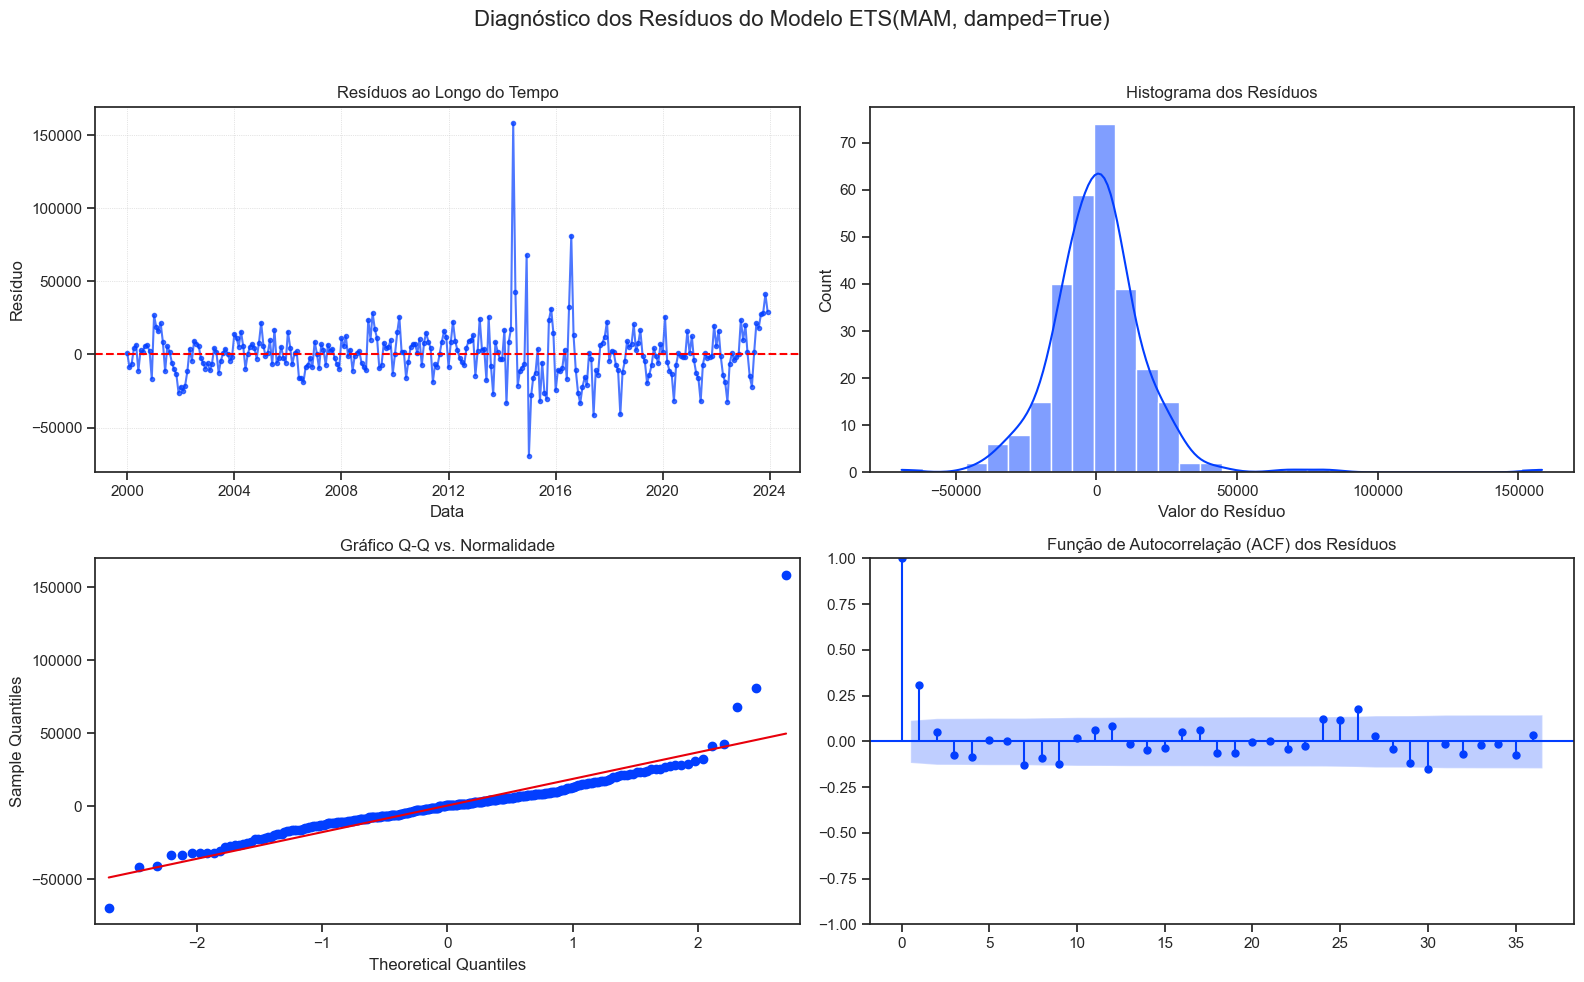

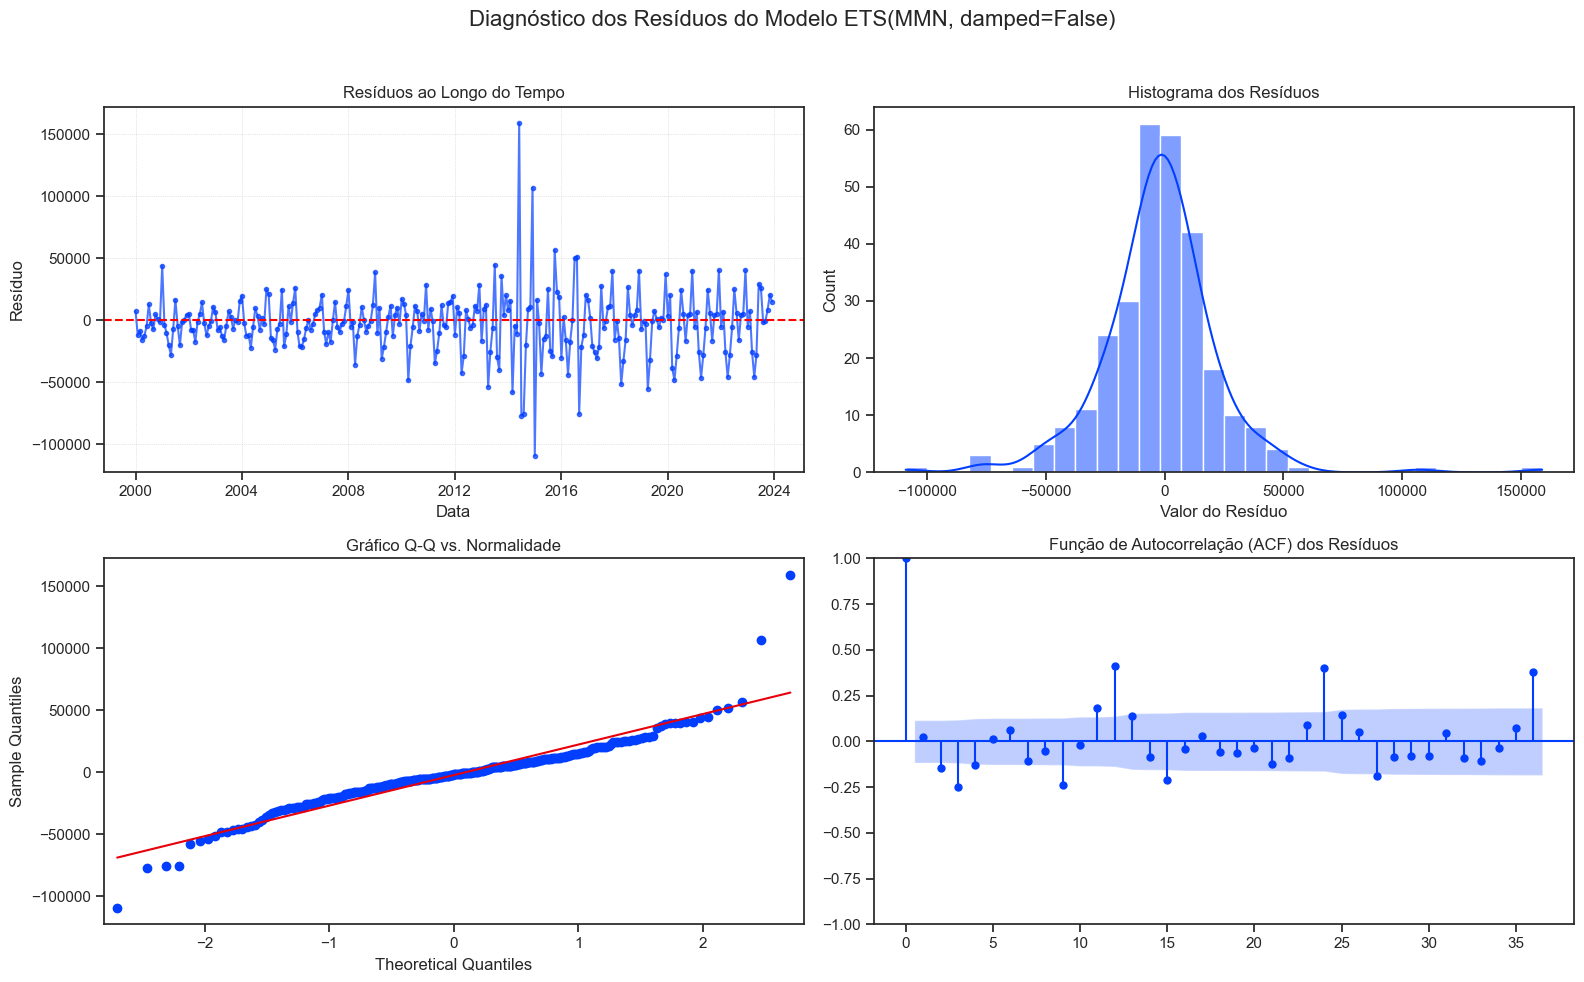

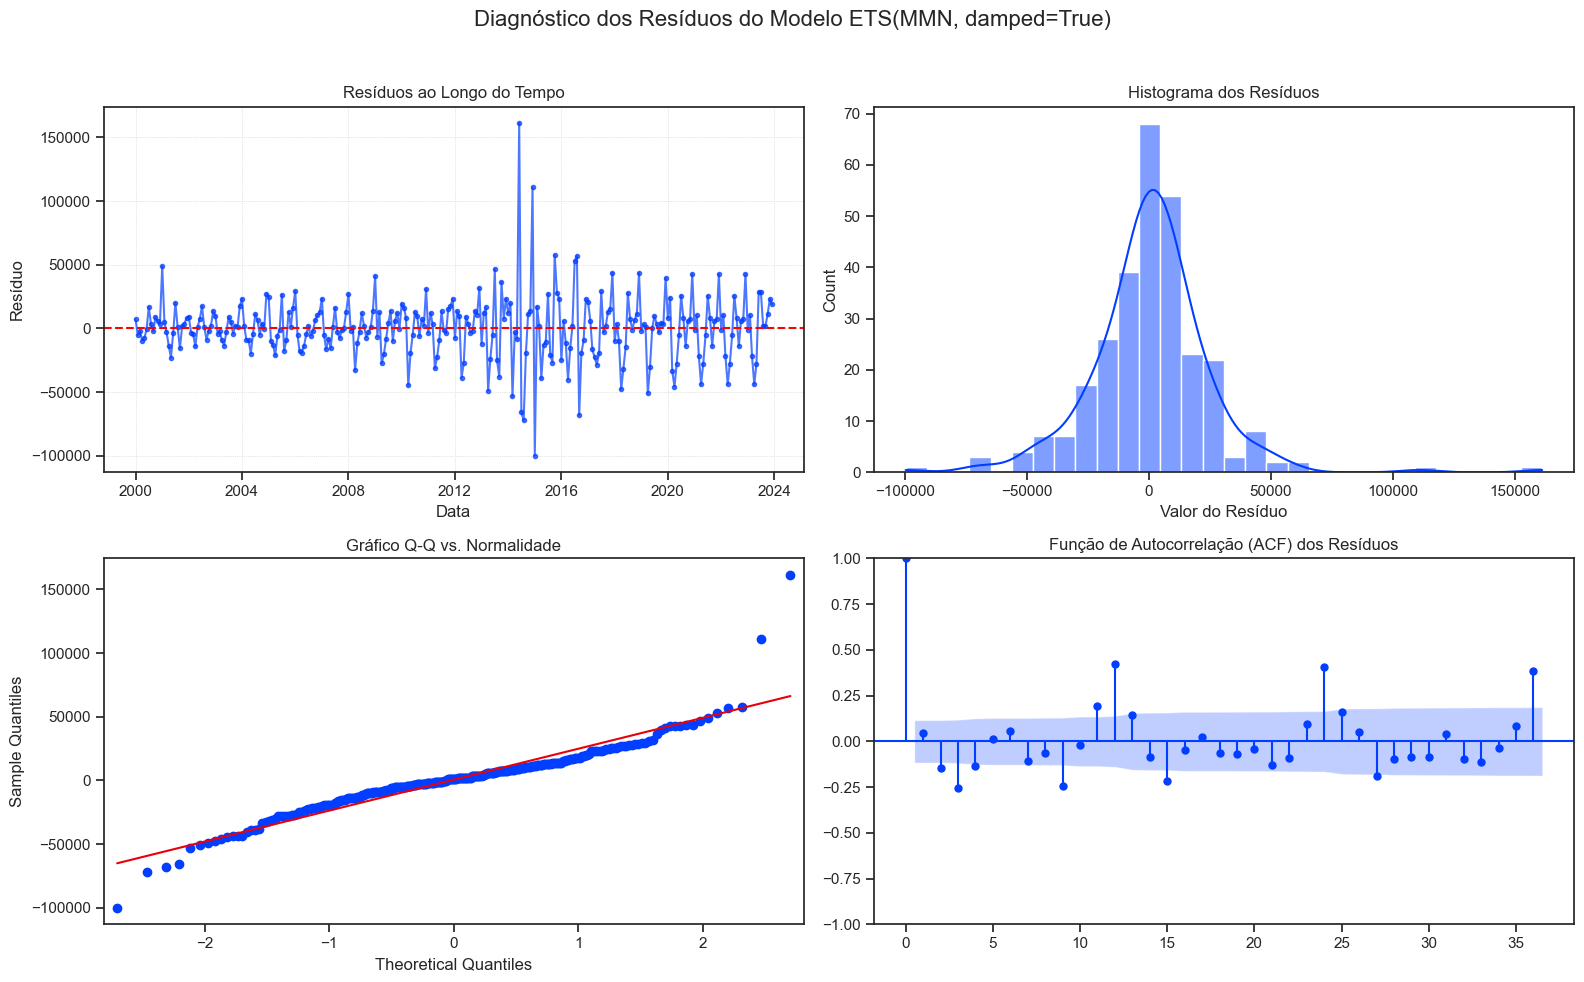

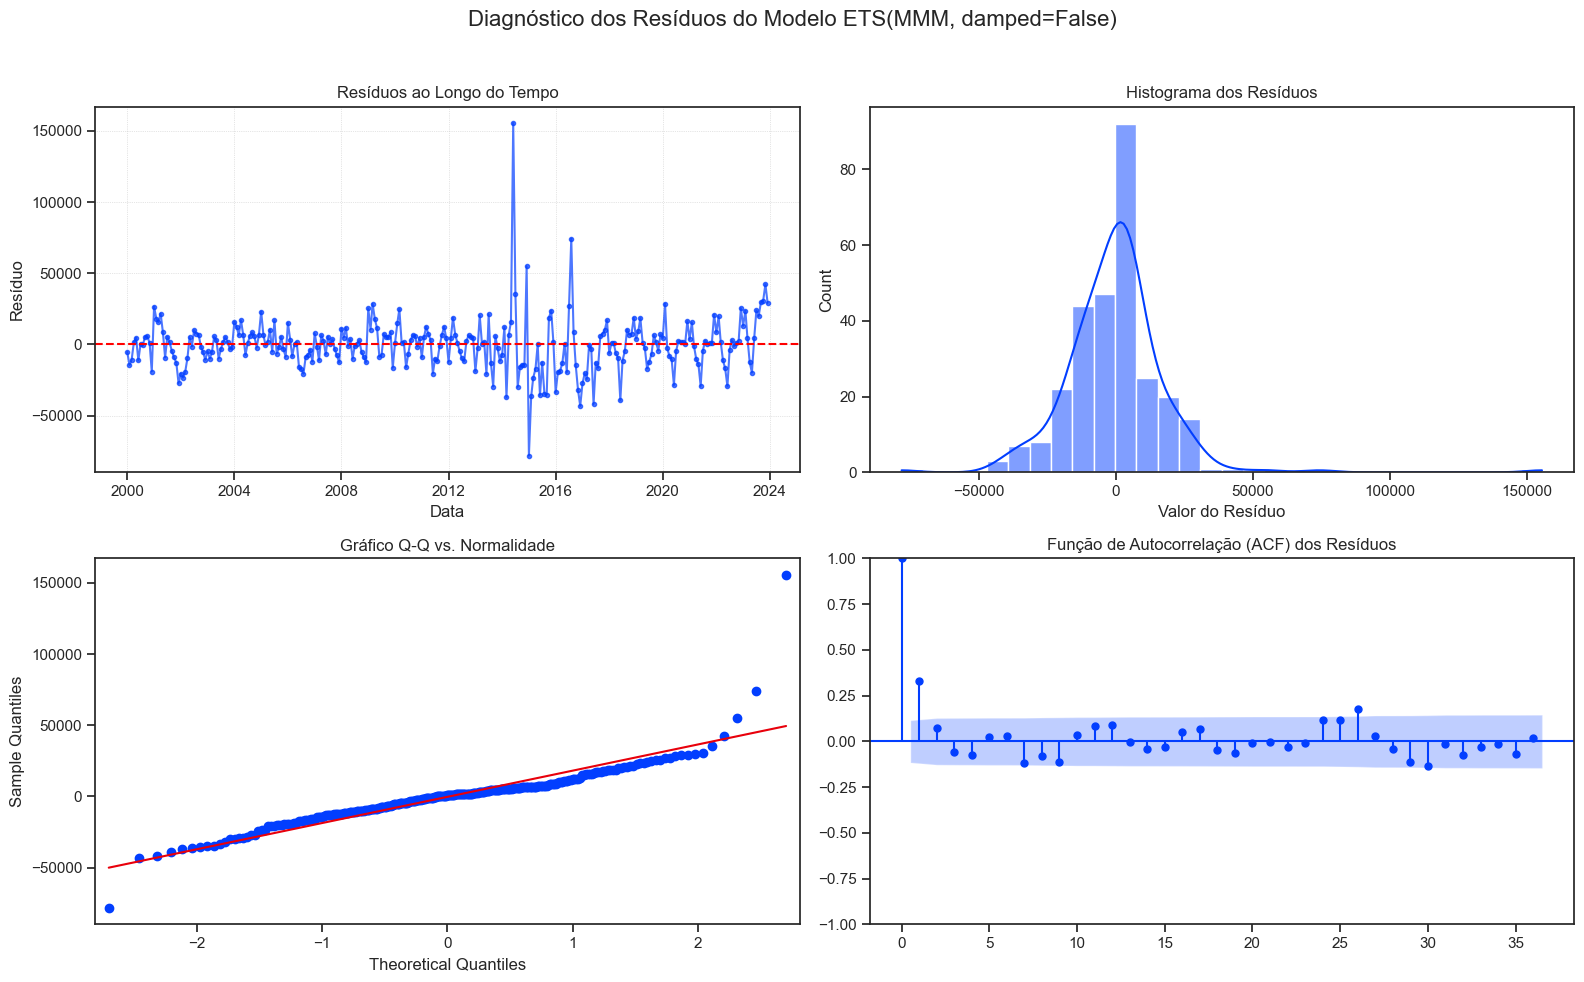

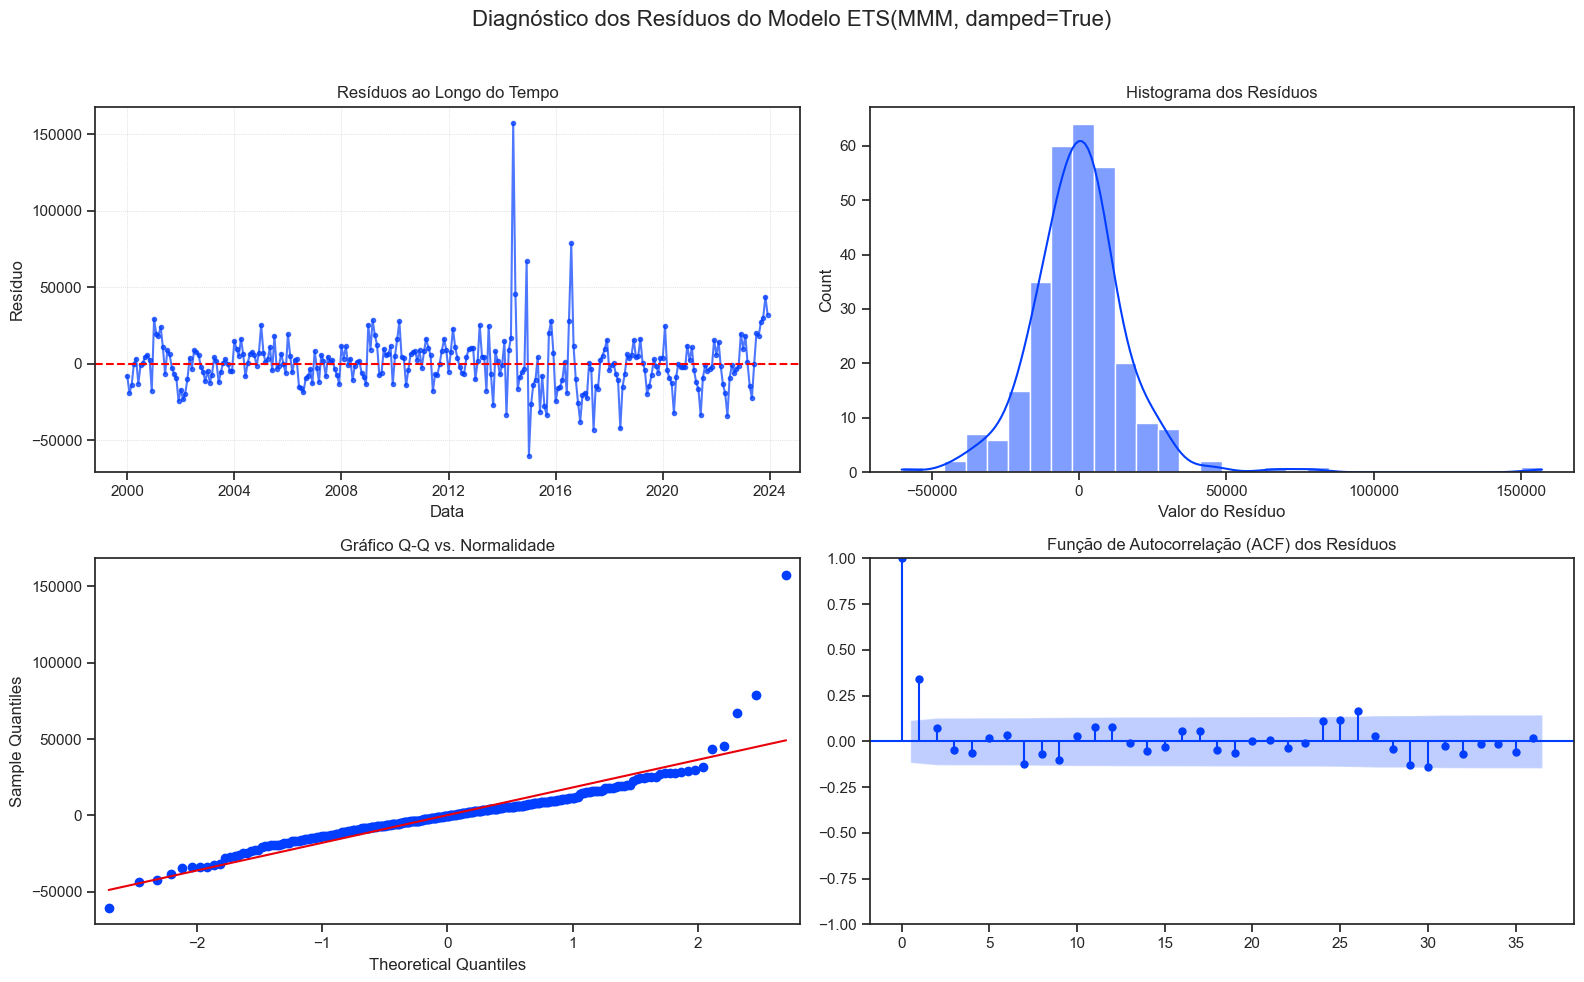


--- Resumo Comparativo de Todos os Modelos ETS ---


model  mape_test     rmse_test      mae_test  mape_train  \
0   ETS(ANN, damped=False)  25.545143  33035.195113  29962.833333   18.816689   
1    ETS(AAN, damped=True)  25.547018  33037.046322  29964.297116   18.710456   
2   ETS(MNN, damped=False)  25.418297  33042.444724  29962.833333   19.004174   
3    ETS(MAN, damped=True)  25.404239  33046.029603  29964.337714   18.921854   
4    ETS(MMN, damped=True)  25.470071  33053.017076  29968.827662   18.896617   
5   ETS(AAN, damped=False)  25.713429  33076.732464  29962.833333   18.840576   
6   ETS(MNA, damped=False)  21.763255  34142.679821  29883.623893   13.181193   
7    ETS(MAA, damped=True)  22.097867  34965.539729  30473.281819   13.170723   
8   ETS(MAA, damped=False)  24.724651  37384.497486  33409.089300   13.256810   
9   ETS(MAM, damped=False)  23.501436  37456.848332  32431.370080   13.374419   
10  ETS(AAA, damped=False)  25.859488  37800.481998  34384.195392   12.676594   
11  ETS(ANA, damped=False)  26.529869  38621.645965  35224.461729   12.624032   
12   ETS(AAA, damped=True)  27.779478  39915.861453  36688.024758   12.796097   
13  ETS(MNM, damped=False)  25.664791  40174.145707  35201.977850   13.382098   
14  ETS(MMN, damped=False)  36.029593  42366.174417  38557.214846   19.527038   
15   ETS(MAM, damped=True)  29.044674  44256.139856  39522.608740   13.803339   
16  ETS(MMM, damped=False)  30.245684  45539.135208  40942.914005   13.972116   
17  ETS(MAN, damped=False)  39.511033  46593.728430  41805.137086   19.405613   
18   ETS(MMM, damped=True)  33.467210  49507.802624  45000.707599   13.876363   
19  ETS(ANM, damped=False)        inf           NaN           NaN         NaN   
20  ETS(AAM, damped=False)        inf           NaN           NaN         NaN   
21   ETS(AAM, damped=True)        inf           NaN           NaN         NaN   
22  ETS(AMN, damped=False)        inf           NaN           NaN         NaN   
23   ETS(AMN, damped=True)        inf           NaN           NaN         NaN   
24  ETS(AMA, damped=False)        inf           NaN           NaN         NaN   
25   ETS(AMA, damped=True)        inf           NaN           NaN         NaN   
26  ETS(AMM, damped=False)        inf           NaN           NaN         NaN   
27   ETS(AMM, damped=True)        inf           NaN           NaN         NaN   
28  ETS(MMA, damped=False)        inf           NaN           NaN         NaN   
29   ETS(MMA, damped=True)        inf           NaN           NaN         NaN   

      rmse_train     mae_train  t_test_pvalue  ljung_box_pvalue  \
0   24311.973743  16324.739971       0.916390      1.445019e-29   
1   24298.127538  16253.814275       0.832807      1.475332e-29   
2   24319.916738  16420.958124       0.901438      1.284564e-31   
3   24309.643354  16365.907826       0.788057      9.323642e-32   
4   24310.904859  16368.390857       0.676474      1.427257e-31   
5   24313.232415  16325.268859       0.998631      1.407143e-29   
6   18319.609895  11495.250837       0.711804      3.056600e-05   
7   18355.372663  11529.786331       0.533904      2.970922e-05   
8   18461.561205  11706.553476       0.454216      8.105225e-05   
9   17891.703097  11492.440972       0.320898      6.975150e-04   
10  18070.716358  11096.037696       0.977056      4.064811e-04   
11  18061.498575  11090.453969       0.675834      3.829039e-04   
12  18088.498434  11203.762079       0.670817      4.713505e-04   
13  17763.735598  11360.035270       0.616367      5.696733e-04   
14  24730.381673  16632.812976       0.120550      1.043857e-29   
15  18250.198686  11793.877039       0.564115      9.960773e-05   
16  18428.616021  12009.198051       0.775692      4.744883e-05   
17  24772.924471  16520.627274       0.006461      2.181499e-22   
18  18118.259519  11753.877071       0.821899      6.944014e-05   
19           NaN           NaN            NaN               NaN   
20           NaN           NaN            NaN               NaN   
21           NaN           NaN     

In [10]:
from statsmodels.stats.diagnostic import het_arch

print("\n--- Comparativo de Todos os Modelos ETS ++ Análise de Resíduos ---")

# Define os componentes do modelo ETS para iterar
error_options = ['A', 'M']
trend_options = ['N', 'A', 'M']
seasonal_options = ['N', 'A', 'M']
damped_options = [False, True]

# Prepara os dados de treino e teste
train_df = pd.DataFrame({
    'unique_id': 'rj',
    'ds': train_series.index,
    'y': train_series.values
})
h = 12

all_model_results = []

# Itera sobre todas as combinações de modelos ETS
for error in error_options:
    for trend in trend_options:
        for seasonal in seasonal_options:
            # A tendência amortecida só se aplica se houver tendência
            damped_iterable = damped_options if trend in ['A', 'M'] else [False]
            for damped in damped_iterable:
                model_str = f"{error}{trend}{seasonal}"
                model_name = f"ETS({model_str}, damped={damped})"
                
                try:
                    # Inicializa o modelo AutoETS com a configuração específica
                    sf_model = StatsForecast(
                        models=[AutoETS(season_length=12, model=model_str, damped=damped)], 
                        freq='MS', 
                        n_jobs=1
                    )

                    # Treina o modelo
                    sf_model.fit(df=train_df)
                    
                    # --- Análise no Teste ---
                    # Faz a previsão para o período de teste
                    forecast_df = sf_model.forecast(df=train_df, h=h, fitted=True)
                    y_pred_test = forecast_df['AutoETS'].values
                    
                    # Garante que os arrays têm o mesmo tamanho para as métricas
                    if len(y_pred_test) == len(test_series.values):
                        # Calcula métricas de teste
                        mape_test = mean_absolute_percentage_error(test_series.values, y_pred_test) * 100
                        rmse_test = np.sqrt(mean_squared_error(test_series.values, y_pred_test))
                        mae_test = mean_absolute_error(test_series.values, y_pred_test)

                        # --- Análise no Treino e Resíduos ---
                        # Obtém os valores ajustados no treino
                        fitted_df = sf_model.forecast_fitted_values()
                        y_pred_train = fitted_df['AutoETS'].values
                        y_true_train = train_df['y'].values
                        
                        # Calcula métricas de treino
                        mape_train = mean_absolute_percentage_error(y_true_train, y_pred_train) * 100
                        rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
                        mae_train = mean_absolute_error(y_true_train, y_pred_train)
                        
                        # Calcula resíduos do treino
                        residuals = y_true_train - y_pred_train
                        
                        # Testes de diagnóstico dos resíduos
                        _, t_pvalue = ttest_1samp(residuals, 0)
                        lb_df = acorr_ljungbox(residuals, lags=[24], return_df=True)
                        lb_pvalue = lb_df['lb_pvalue'].iloc[-1]
                        _, jb_pvalue = stats.jarque_bera(residuals)
                        arch_test = het_arch(residuals, nlags=12)
                        arch_pvalue = arch_test[1]

                        # --- Plots de Diagnóstico ---
                        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
                        fig.suptitle(f'Diagnóstico dos Resíduos do Modelo {model_name}', fontsize=16)

                        # Plot 1: Resíduos ao longo do tempo
                        axes[0, 0].plot(train_df['ds'], residuals, marker='o', linestyle='-', markersize=3, alpha=0.7)
                        axes[0, 0].axhline(0, color='red', linestyle='--')
                        axes[0, 0].set_title('Resíduos ao Longo do Tempo')
                        axes[0, 0].set_xlabel('Data')
                        axes[0, 0].set_ylabel('Resíduo')
                        axes[0, 0].grid(True, which='both', linestyle=':', linewidth=0.5)

                        # Plot 2: Histograma dos resíduos
                        sns.histplot(residuals, kde=True, ax=axes[0, 1], bins=30)
                        axes[0, 1].set_title('Histograma dos Resíduos')
                        axes[0, 1].set_xlabel('Valor do Resíduo')

                        # Plot 3: Gráfico Q-Q (Quantil-Quantil)
                        sm.qqplot(residuals, line='s', ax=axes[1, 0])
                        axes[1, 0].set_title('Gráfico Q-Q vs. Normalidade')

                        # Plot 4: Gráfico de Autocorrelação (ACF)
                        sm.graphics.tsa.plot_acf(residuals, ax=axes[1, 1], lags=36)
                        axes[1, 1].set_title('Função de Autocorrelação (ACF) dos Resíduos')

                        plt.tight_layout(rect=[0, 0, 1, 0.96])
                        plt.show()
                        
                        # Armazena os resultados
                        all_model_results.append({
                            'model': model_name,
                            'mape_test': mape_test,
                            'rmse_test': rmse_test,
                            'mae_test': mae_test,
                            'mape_train': mape_train,
                            'rmse_train': rmse_train,
                            'mae_train': mae_train,
                            't_test_pvalue': t_pvalue,
                            'ljung_box_pvalue': lb_pvalue,
                            'jarque_bera_pvalue': jb_pvalue
                            ,'arch_pvalue': arch_pvalue
                        })
                    else:
                        all_model_results.append({'model': model_name, 'mape_test': float('inf')})


                except Exception as e:
                    all_model_results.append({'model': model_name, 'mape_test': float('inf')})

# Converte a lista de resultados em um DataFrame
results_summary_df = pd.DataFrame(all_model_results)

# Exibe o DataFrame ordenado pelo RMSE de teste
print("\n--- Resumo Comparativo de Todos os Modelos ETS ---")
display(results_summary_df.sort_values(by='rmse_test').reset_index(drop=True))

Nenhum dos modelos ETS passa no teste de Ljung-Box, logo não há autocorrelação entre os resíduos e os modelos ETS não são úteis para modelar.

Concatena os continentes

In [11]:
df_rj_continente = process_df(df=df, state="rio_de_janeiro", agg_cols=["date","continent","continent_id"], value_cols="arrivals", agg_func="sum")
df_rj_continente.tail()

date         continent  continent_id  arrivals
2095 2024-12-01  america_do_norte             3   29679.0
2096 2024-12-01    america_do_sul             4   99840.0
2097 2024-12-01              asia             5    2651.0
2098 2024-12-01            europa             6   39981.0
2099 2024-12-01           oceania             7    1623.0

Separa os continentes

In [12]:
# Pivota o dataframe para que cada continente seja uma coluna, com a data como índice
df_continentes_pivot = df_rj_continente.pivot(
    index='date', 
    columns='continent', 
    values='arrivals'
)

# Cria um dicionário onde cada chave é o nome de um continente e o valor é a série temporal correspondente
series_por_continente = {
    continente: df_continentes_pivot[continente] for continente in df_continentes_pivot.columns
}

# Exibe as primeiras 5 linhas do dataframe pivotado para verificação
print("DataFrame Pivotado (cada coluna é uma série temporal):")
print(df_continentes_pivot.head())

# Exemplo de como acessar uma série temporal específica (ex: Europa)
print("\nExemplo de acesso à série da Europa:")
print(series_por_continente['europa'].head())

DataFrame Pivotado (cada coluna é uma série temporal):
continent   africa  america_central_e_caribe  america_do_norte  \
date                                                             
2000-01-01  1667.0                     449.0           22202.0   
2000-02-01  1538.0                     385.0           19060.0   
2000-03-01  1445.0                     377.0           17767.0   
2000-04-01  1198.0                     302.0           14761.0   
2000-05-01  1024.0                     251.0           12601.0   

continent   america_do_sul    asia   europa  oceania  
date                                                  
2000-01-01         22097.0  2902.0  41142.0    859.0  
2000-02-01         19790.0  2552.0  36330.0    769.0  
2000-03-01         18723.0  2392.0  34287.0    725.0  
2000-04-01         15469.0  2069.0  28554.0    604.0  
2000-05-01         13221.0  1758.0  24480.0    520.0  

Exemplo de acesso à série da Europa:
date
2000-01-01    41142.0
2000-02-01    36330.0
2000-03-01

Imputando período COVID/Continente

            africa  america_central_e_caribe  america_do_norte  \
date                                                             
2000-01-01  1667.0                     449.0           22202.0   
2000-02-01  1538.0                     385.0           19060.0   
2000-03-01  1445.0                     377.0           17767.0   
2000-04-01  1198.0                     302.0           14761.0   
2000-05-01  1024.0                     251.0           12601.0   

            america_do_sul    asia   europa  oceania  
date                                                  
2000-01-01         22097.0  2902.0  41142.0    859.0  
2000-02-01         19790.0  2552.0  36330.0    769.0  
2000-03-01         18723.0  2392.0  34287.0    725.0  
2000-04-01         15469.0  2069.0  28554.0    604.0  
2000-05-01         13221.0  1758.0  24480.0    520.0  


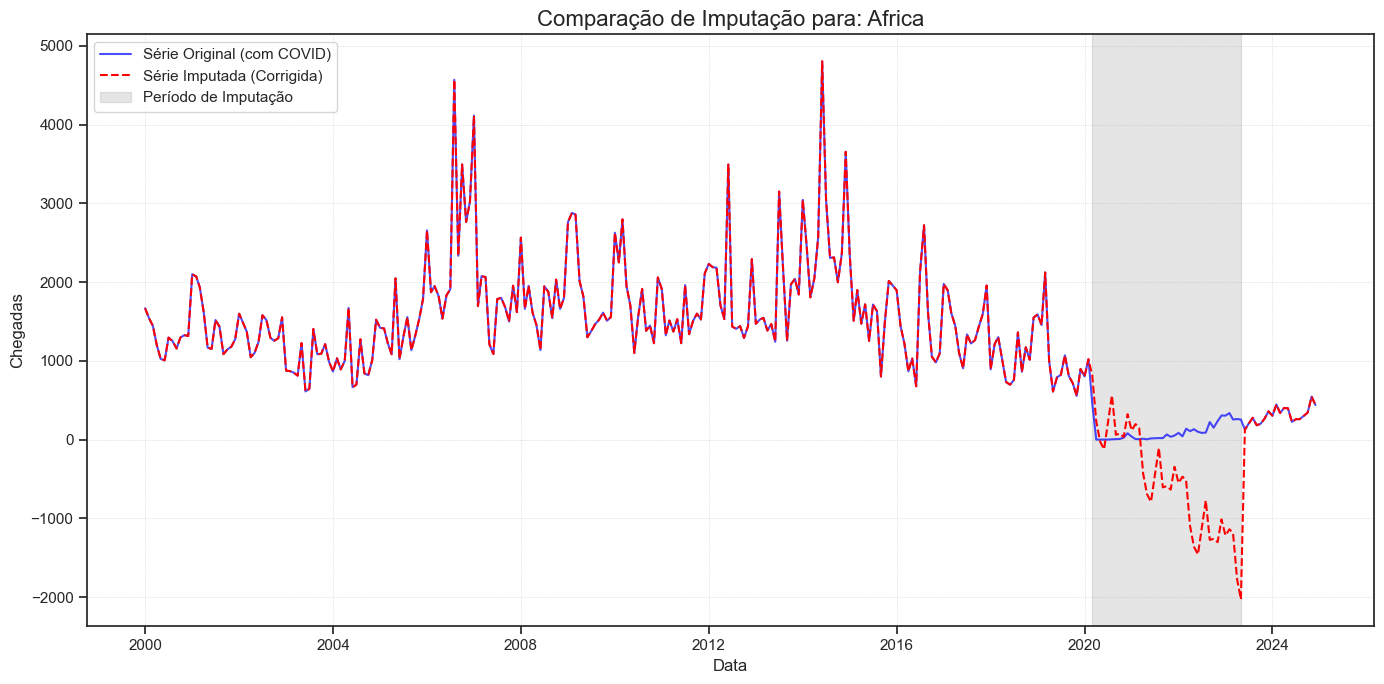

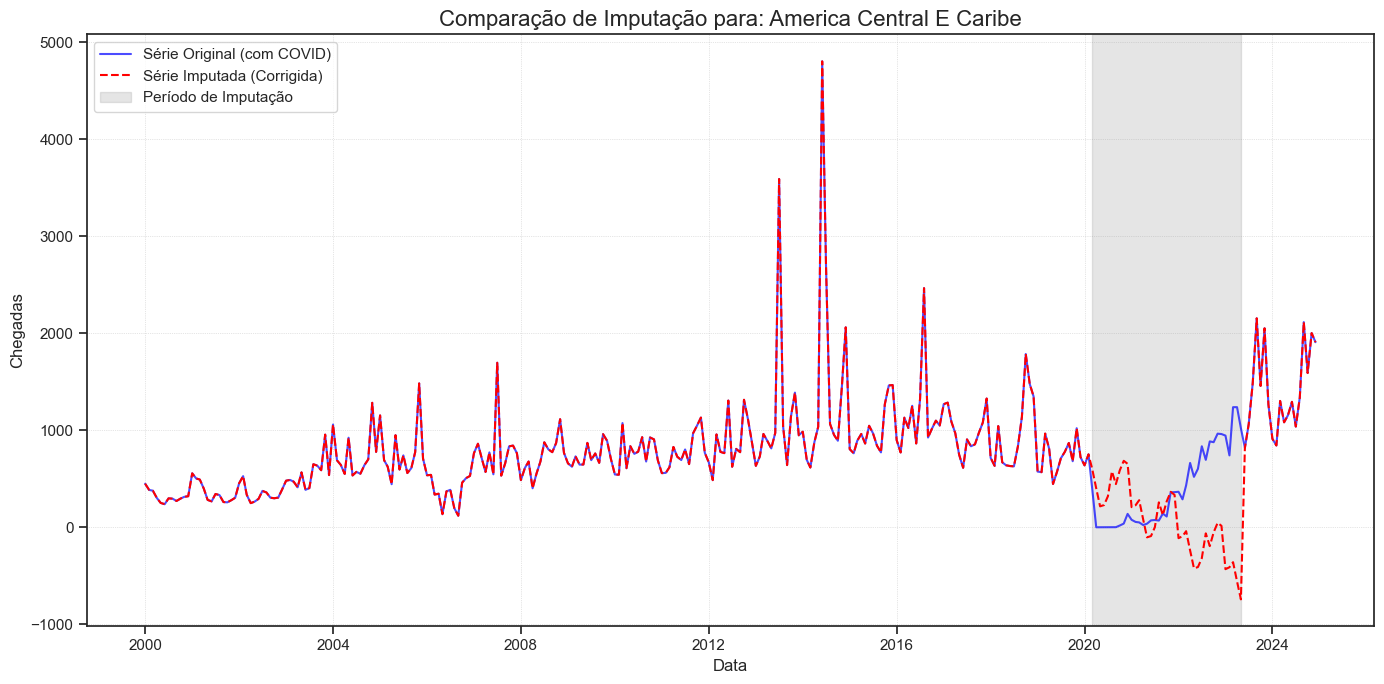

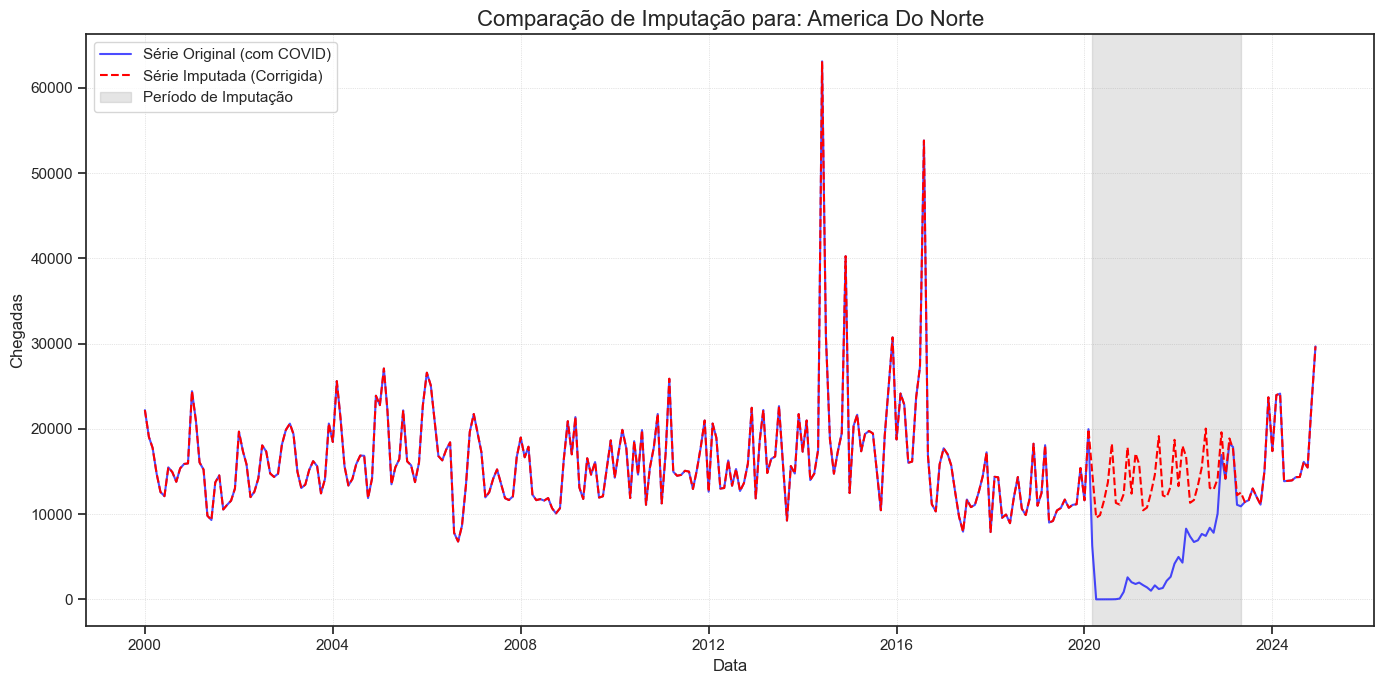

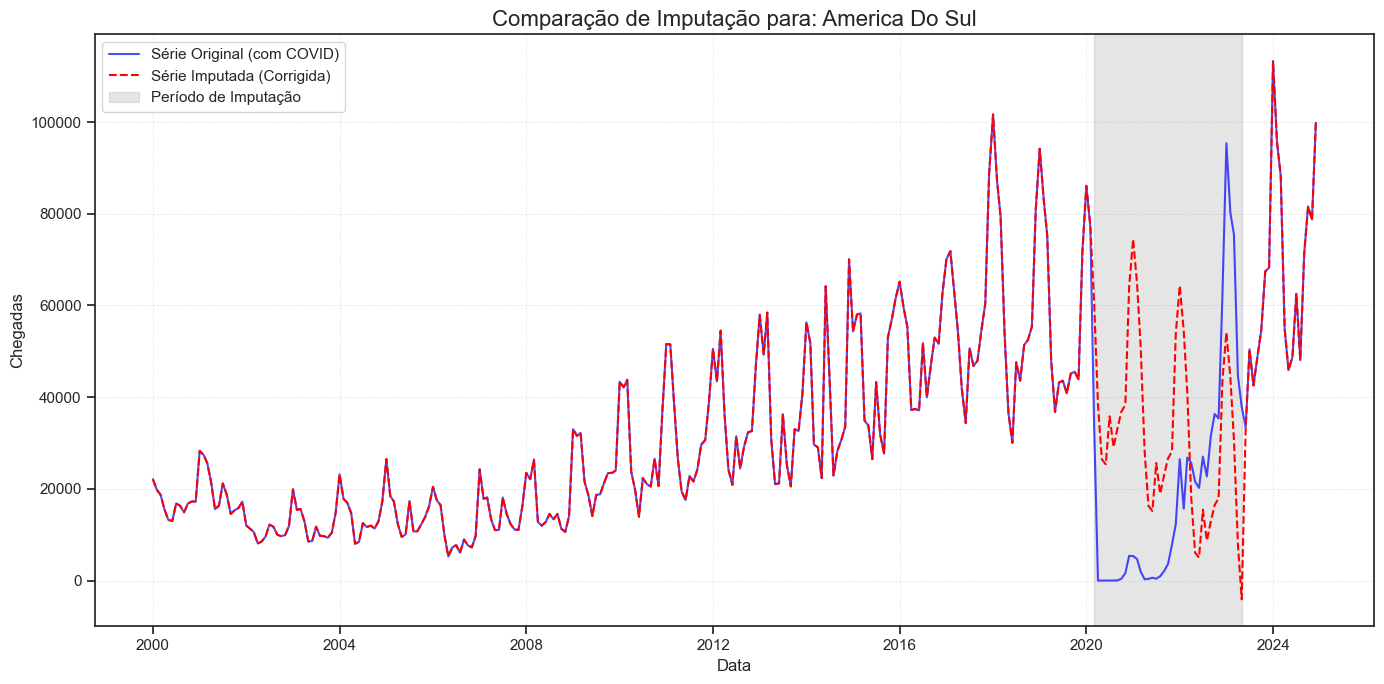

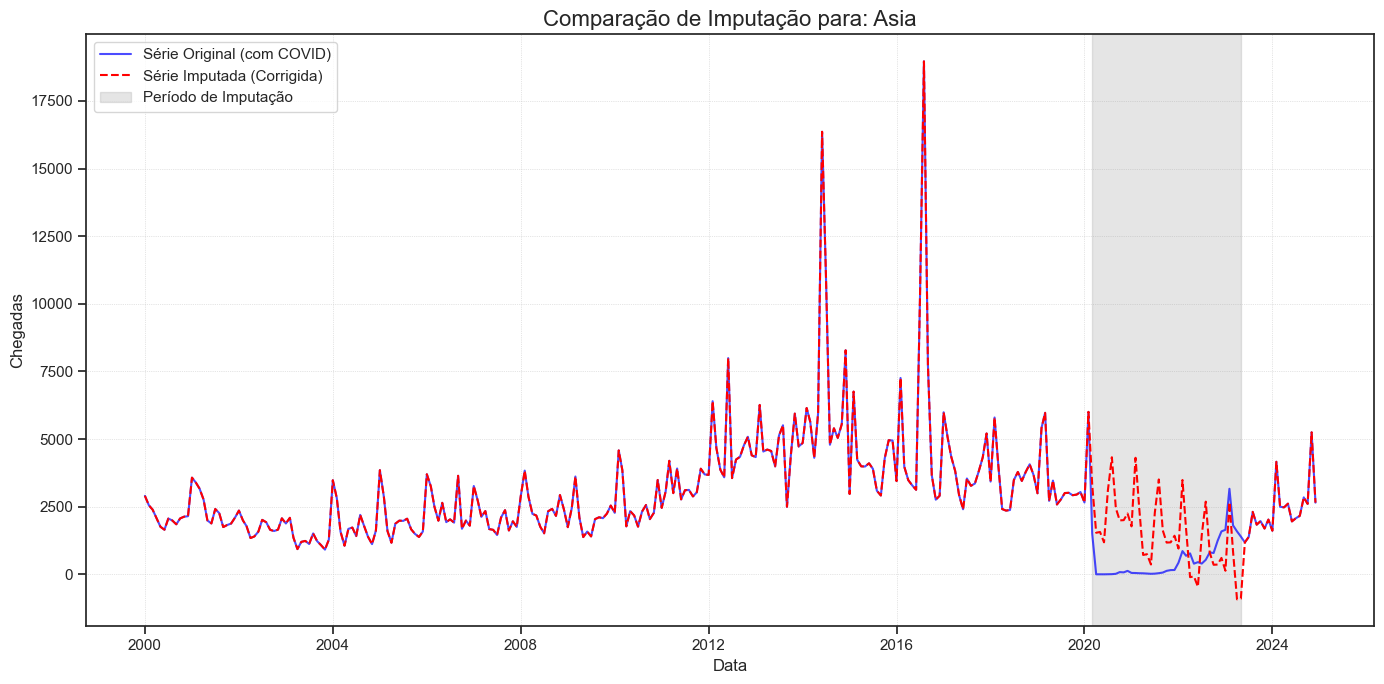

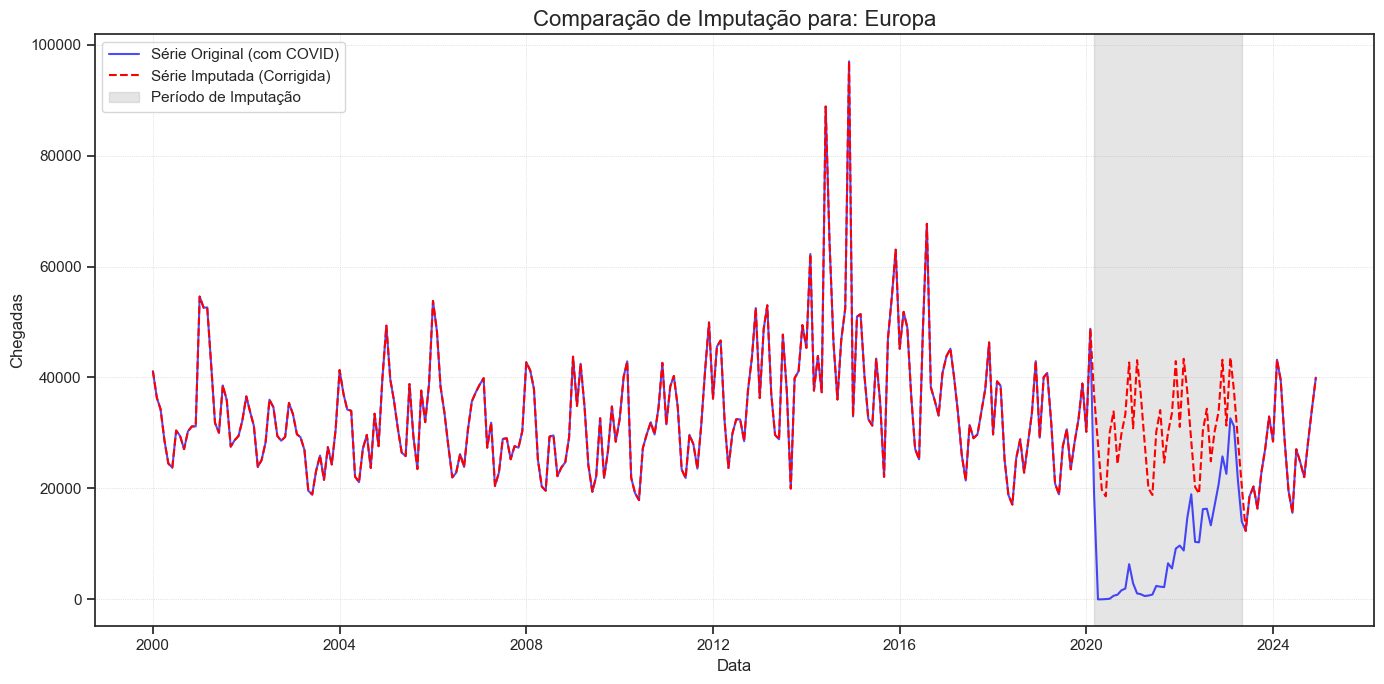

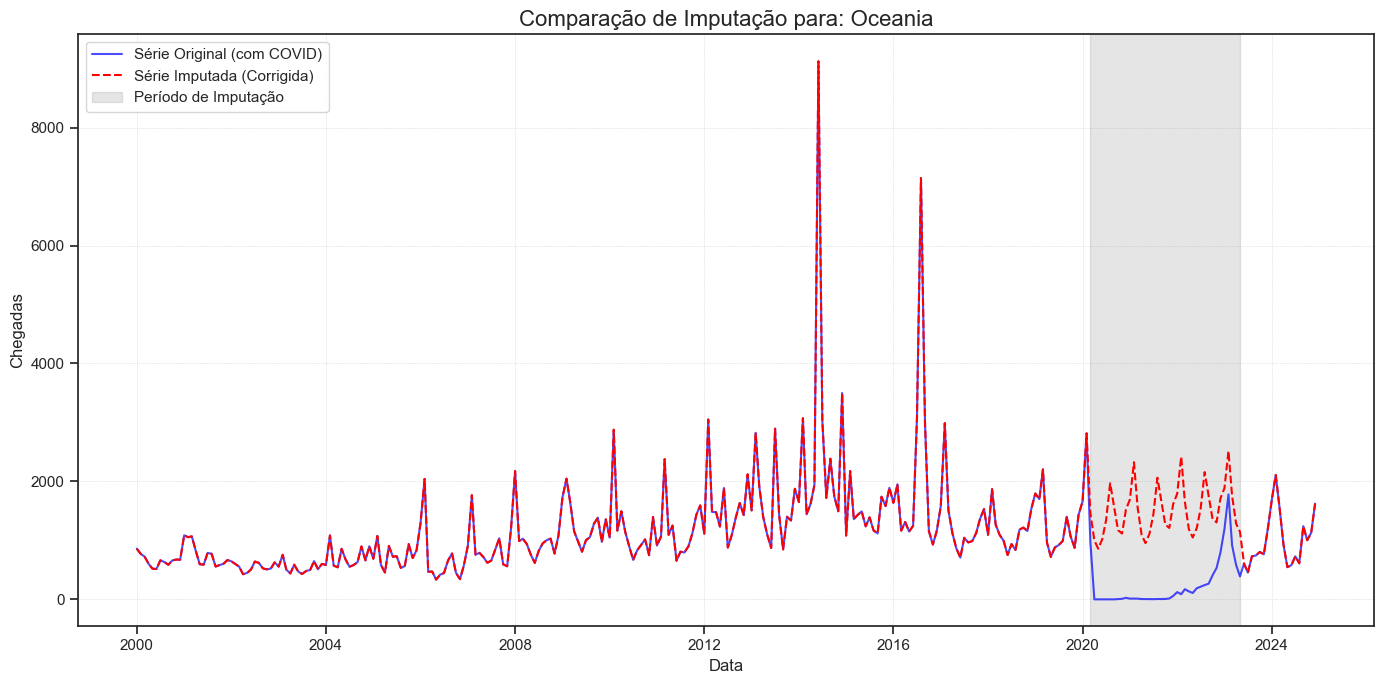

In [13]:
# Imputação do período COVID para cada continente (mesma lógica usada anteriormente)
imputed_continent_series = {}

for continente, serie in series_por_continente.items():
    s = serie.copy()
    # intervalo do gap segundo a série (preserva índice exato)
    indice_gap = s.loc[COVID_START:COVID_END].index
    n_meses_gap = len(indice_gap)
    if n_meses_gap == 0:
        imputed_continent_series[continente] = s
        continue

    # usa apenas pré-COVID para ajustar STL
    pre_covid = s.loc[:PRE_COVID_END].dropna()
    try:
        stl_c = STL(pre_covid, period=12, seasonal=13).fit()

        # componente sazonal: repete o último ano sazonal conforme necessário
        ultimo_ano_sazonal = stl_c.seasonal[-12:]
        n_repeticoes = int(np.ceil(n_meses_gap / 12))
        valores_sazonais_projetados = np.tile(ultimo_ano_sazonal.values, n_repeticoes)[:n_meses_gap]
        sazonal_imputado = pd.Series(valores_sazonais_projetados, index=indice_gap)

        # componente tendência: ajusta reta ao último segmento de tendência (12 meses) e projeta
        segmento_tendencia_recente = stl_c.trend.dropna().iloc[-12:]
        x = np.arange(len(segmento_tendencia_recente))
        y = segmento_tendencia_recente.values
        coefs = np.polyfit(x, y, 1)  # [slope, intercept]
        slope = coefs[0]
        ultimo_valor_tendencia = segmento_tendencia_recente.iloc[-1]
        x_projecao = np.arange(1, n_meses_gap + 1)
        valores_tendencia_projetados = (slope * x_projecao) + ultimo_valor_tendencia
        tendencia_imputada = pd.Series(valores_tendencia_projetados, index=indice_gap)

        # soma tendência + sazonal para obter imputação
        valores_imputados = tendencia_imputada + sazonal_imputado

        s_imputada = s.copy()
        s_imputada.loc[COVID_START:COVID_END] = valores_imputados
        imputed_continent_series[continente] = s_imputada

    except Exception as e:
        # se falhar, mantém a série original e informa
        print(f"Erro ao imputar {continente}: {e}")
        imputed_continent_series[continente] = s

# Monta DataFrame pivotado com séries imputadas (mesmo formato de df_continentes_pivot)
df_continentes_pivot_imputado = pd.DataFrame(imputed_continent_series).sort_index()
df_continentes_pivot_imputado.index.name = 'date'

# Converte para formato longo (ds, unique_id, y) compatível com Y_df_h
Y_df_h_imputado = (
    df_continentes_pivot_imputado
    .reset_index()
    .melt(id_vars='date', var_name='unique_id', value_name='y')
    .rename(columns={'date': 'ds'})
)

# Saída rápida para verificação
print(df_continentes_pivot_imputado.head())

# Plot da comparação para cada continente
for continente, serie_imputada in imputed_continent_series.items():
    serie_original = series_por_continente[continente]
    
    plt.figure(figsize=(14, 7))
    
    # Plota a série original
    plt.plot(serie_original.index, serie_original.values, 
             label='Série Original (com COVID)', color='blue', alpha=0.7)
    
    # Plota a série imputada
    plt.plot(serie_imputada.index, serie_imputada.values, 
             label='Série Imputada (Corrigida)', color='red', linestyle='--')
    
    # Destaca o período de imputação
    plt.axvspan(pd.to_datetime(COVID_START), pd.to_datetime(COVID_END), 
                color='gray', alpha=0.2, label=f'Período de Imputação')
    
    # Configurações do gráfico
    plt.title(f'Comparação de Imputação para: {continente.replace("_", " ").title()}', fontsize=16)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Chegadas', fontsize=12)
    plt.legend()
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

ETS Continente


--- AFRICA ---
RMSE (Treino): 476.88
MAPE (Treino): 40.21%
MAE (Treino): 317.28
RMSE (2024): 282.83
MAPE (2024): 68.56%
MAE (2024): 239.20


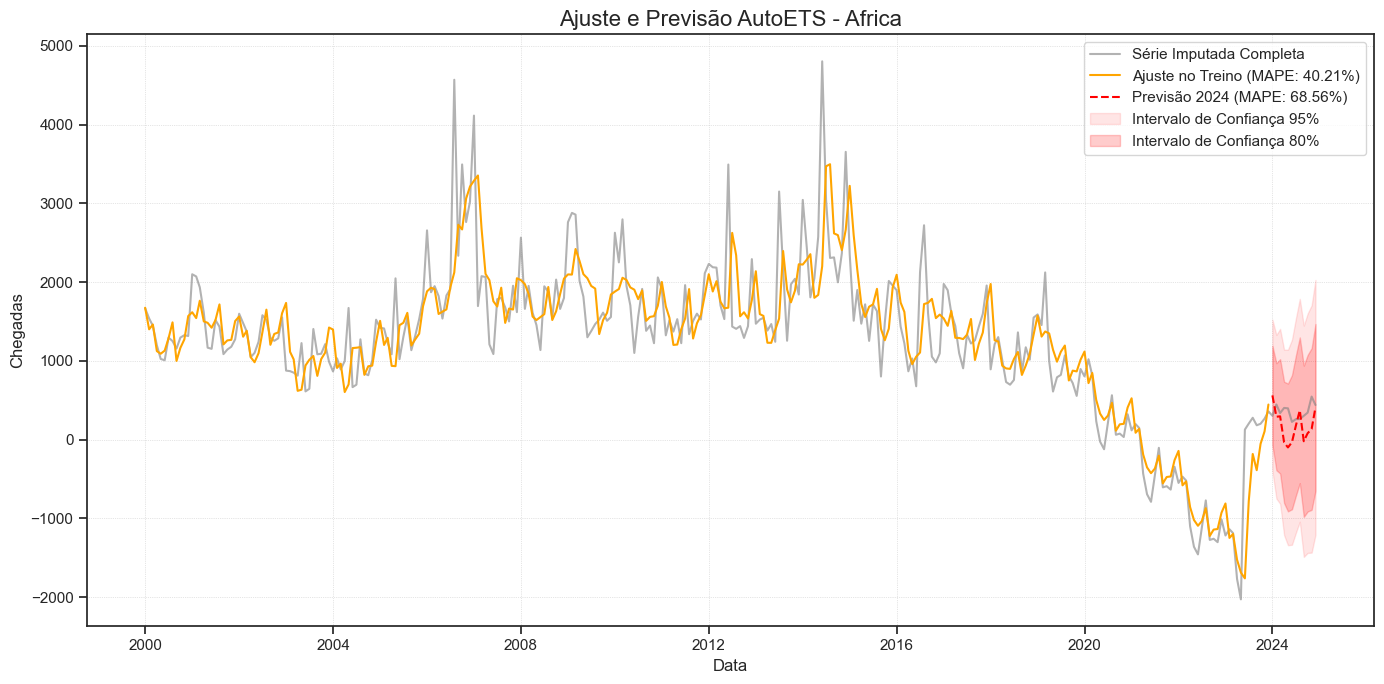


--- AMERICA_CENTRAL_E_CARIBE ---
RMSE (Treino): 403.90
MAPE (Treino): 141.23%
MAE (Treino): 226.68
RMSE (2024): 355.82
MAPE (2024): 20.49%
MAE (2024): 272.77


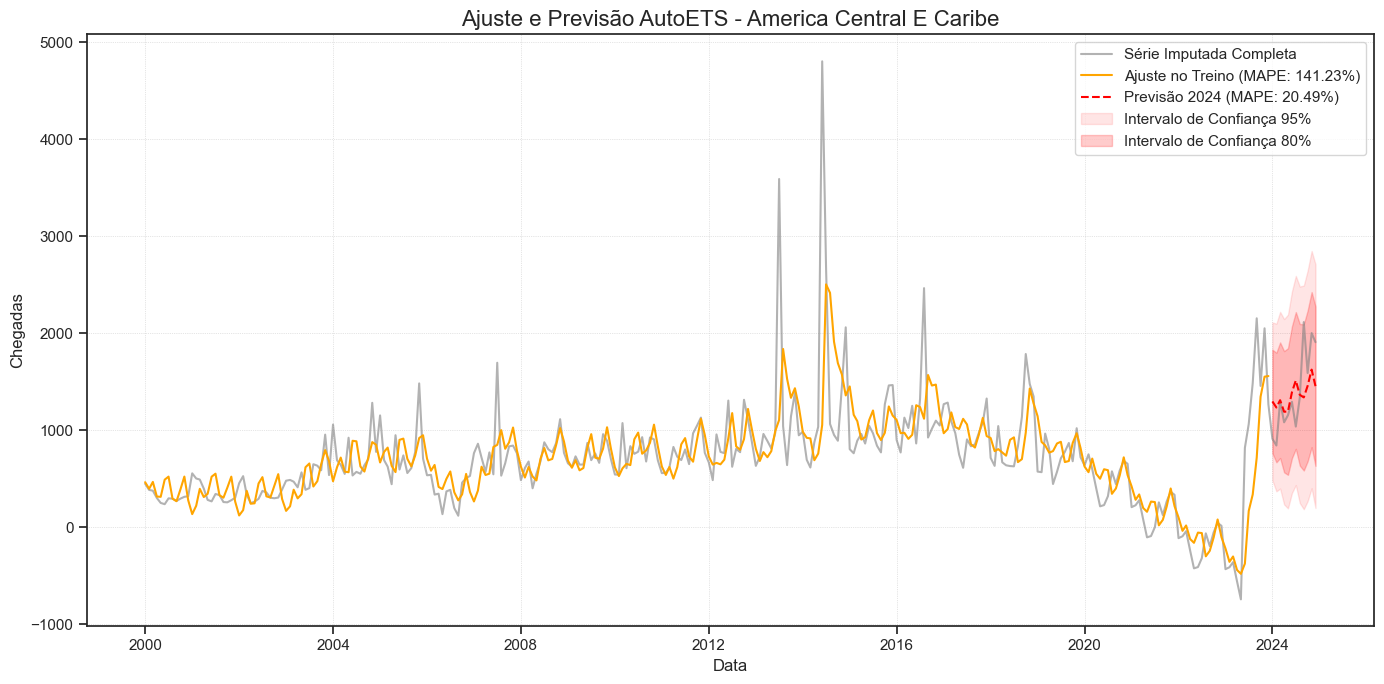


--- AMERICA_DO_NORTE ---
RMSE (Treino): 4763.31
MAPE (Treino): 18.30%
MAE (Treino): 2842.90
RMSE (2024): 5532.56
MAPE (2024): 22.94%
MAE (2024): 4562.21


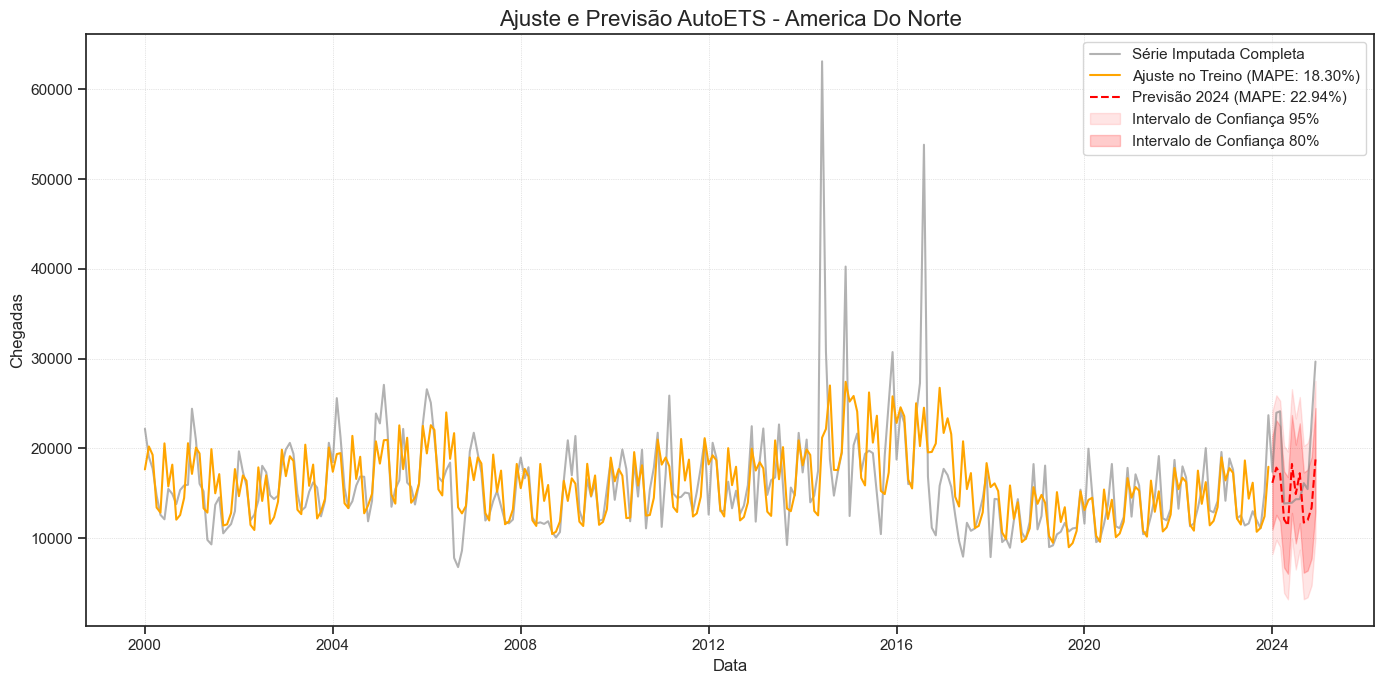


--- AMERICA_DO_SUL ---
RMSE (Treino): 6976.53
MAPE (Treino): 16.98%
MAE (Treino): 4606.17
RMSE (2024): 21620.12
MAPE (2024): 27.02%
MAE (2024): 20202.31


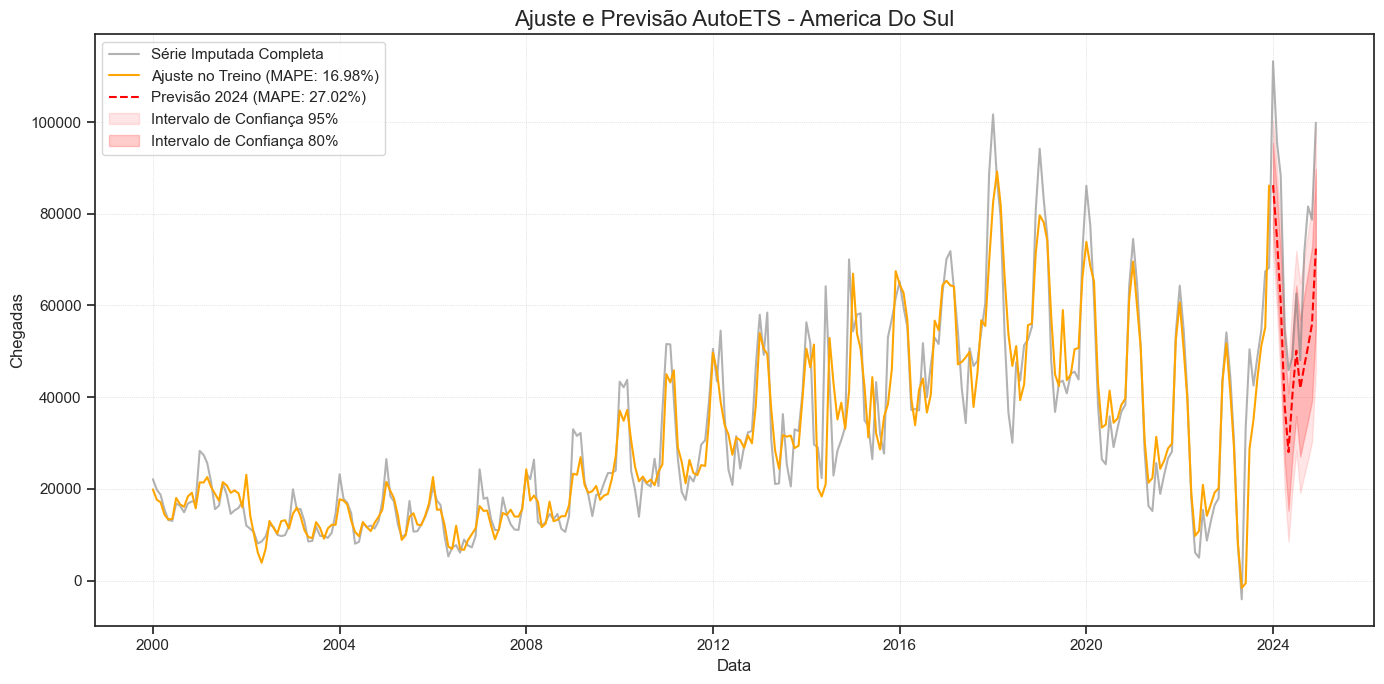


--- ASIA ---
RMSE (Treino): 1466.76
MAPE (Treino): 40.43%
MAE (Treino): 827.49
RMSE (2024): 1475.11
MAPE (2024): 35.32%
MAE (2024): 1099.05


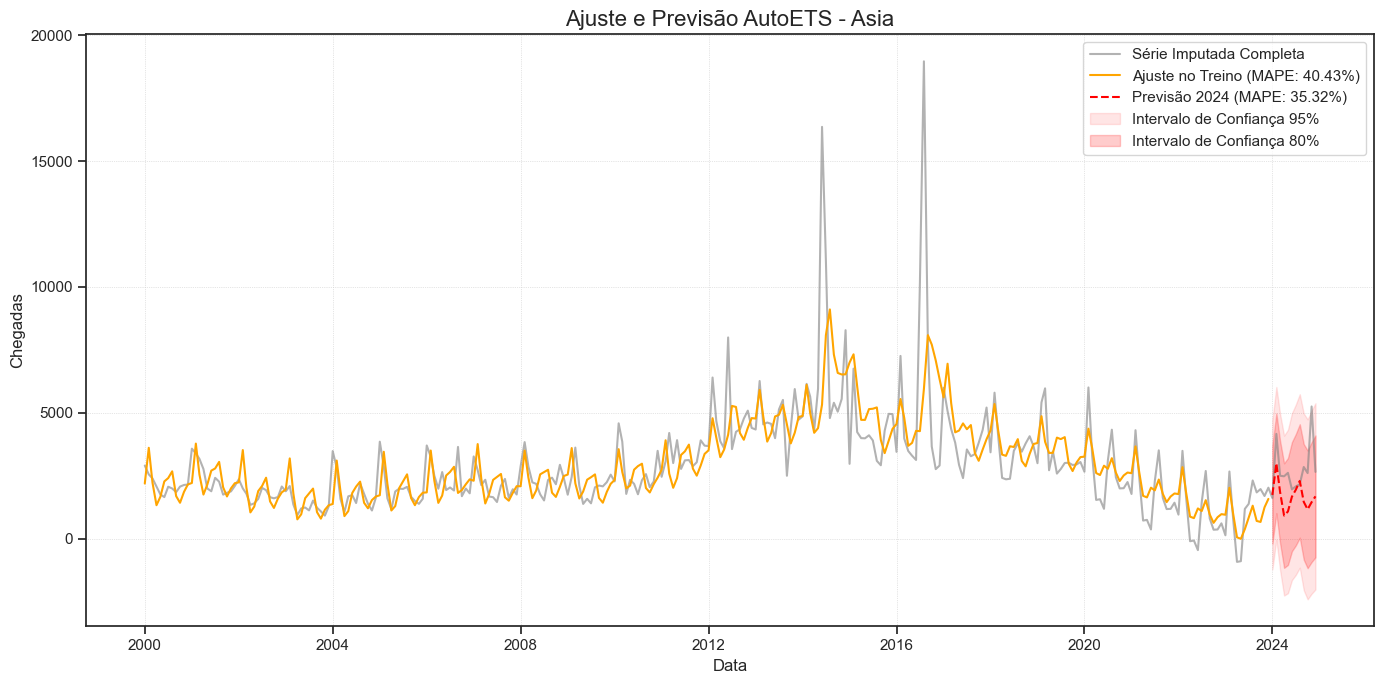


--- EUROPA ---
RMSE (Treino): 7254.03
MAPE (Treino): 13.43%
MAE (Treino): 4592.37
RMSE (2024): 6275.83
MAPE (2024): 17.56%
MAE (2024): 5383.23


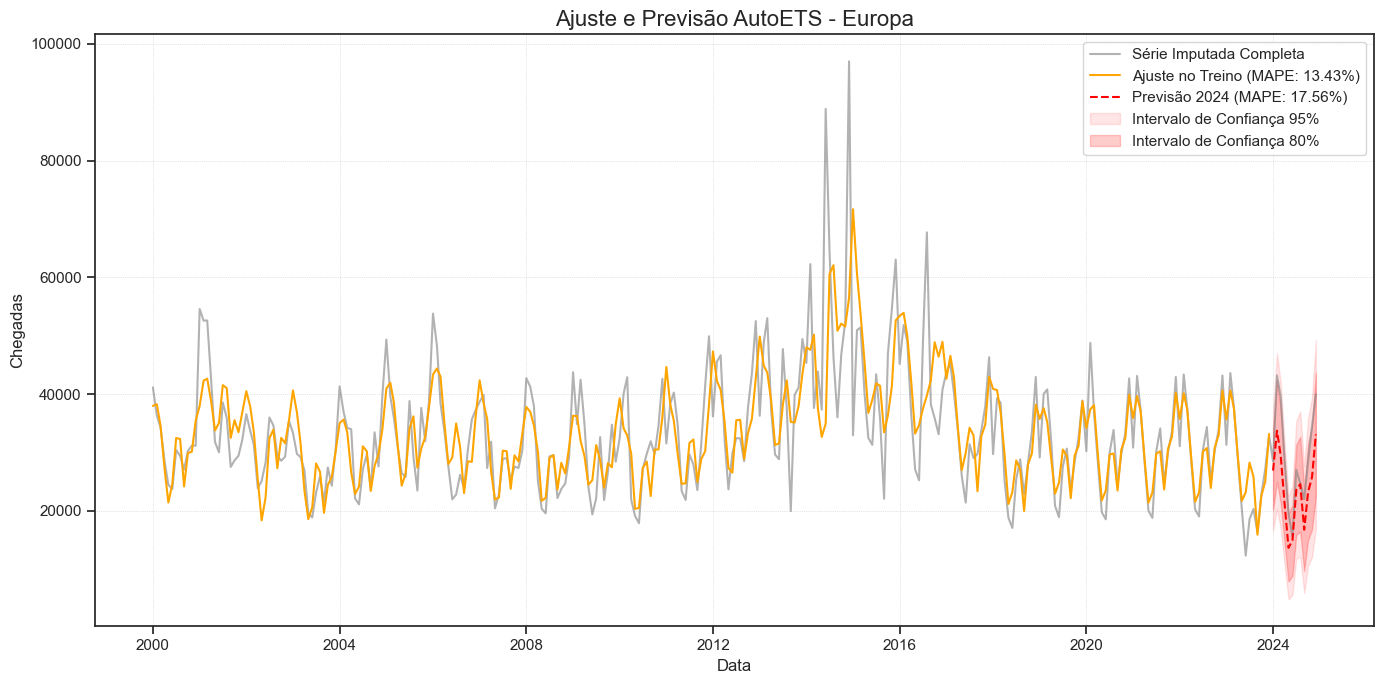


--- OCEANIA ---
RMSE (Treino): 694.22
MAPE (Treino): 33.03%
MAE (Treino): 381.48
RMSE (2024): 477.14
MAPE (2024): 46.00%
MAE (2024): 400.16


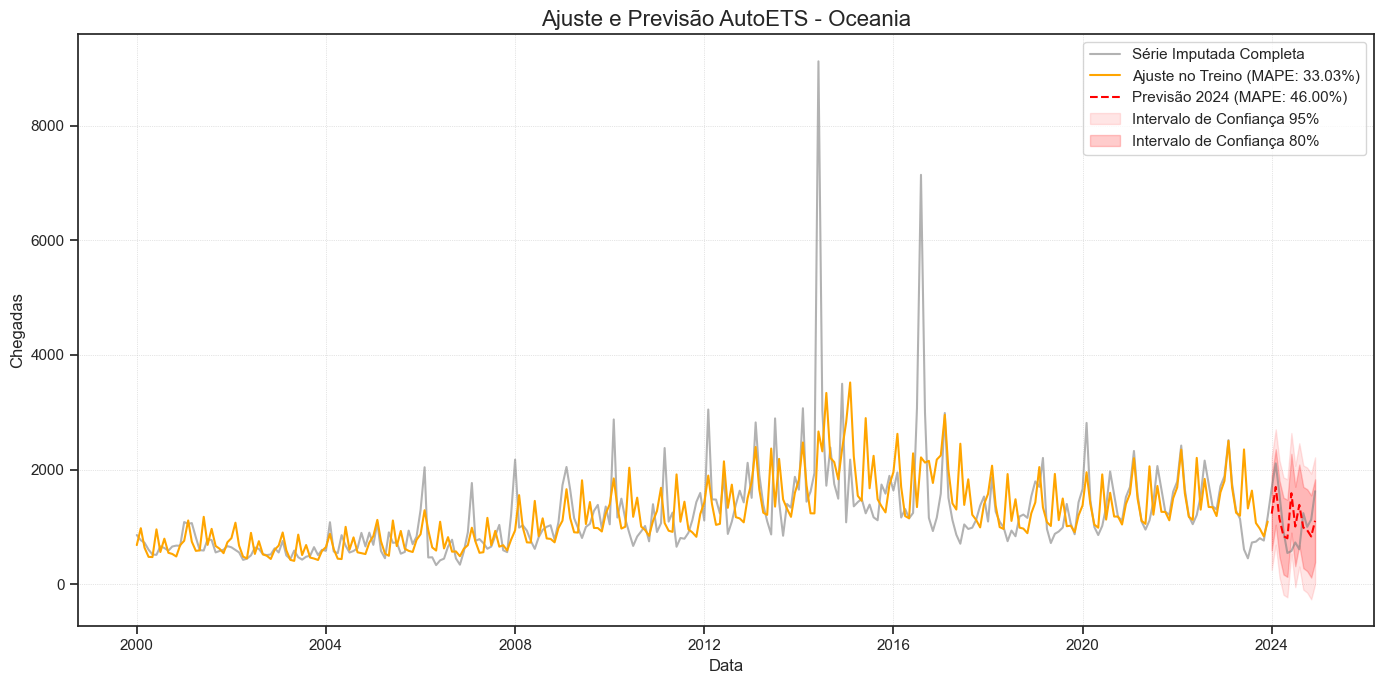

In [14]:
# Treino e teste AutoETS por continente

train_end = '2023-12-31'
test_start = '2024-01-01'
test_end = '2024-12-31'
h = 12

for continente in Y_df_h_imputado['unique_id'].unique():
    print(f"\n--- {continente.upper()} ---")
    # Dados de treino (imputados) e teste (originais) para o continente
    train_df = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continente) &
        (Y_df_h_imputado['ds'] <= train_end)
    ].copy()
    test_df = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continente) &
        (Y_df_h_imputado['ds'] >= test_start)
    ].copy()

    # Série original (não imputada) para o período de teste
    test_series = series_por_continente[continente].loc[test_start:test_end]
    y_true_teste = test_series.values

    # Treina modelo
    sf = StatsForecast(models=[AutoETS(season_length=12)], freq='MS', n_jobs=1)
    sf.fit(df=train_df)

    # Previsão para horizonte de teste
    forecasts = sf.forecast(df=train_df, h=h, level=[80,95], fitted=True)
    pred_index = pd.to_datetime(forecasts['ds'])
    y_pred_teste = forecasts['AutoETS'].values

    # Métricas teste
    rmse_val = np.sqrt(mean_squared_error(y_true_teste, y_pred_teste))
    mape_val = mean_absolute_percentage_error(y_true_teste, y_pred_teste) * 100
    mae_val = mean_absolute_error(y_true_teste, y_pred_teste)

    # Ajuste no treino
    fitted_values_df = sf.forecast_fitted_values()
    y_true_treino = train_df['y'].values
    y_pred_treino = fitted_values_df['AutoETS'].values

    rmse_treino = np.sqrt(mean_squared_error(y_true_treino, y_pred_treino))
    mape_treino = mean_absolute_percentage_error(y_true_treino, y_pred_treino) * 100
    mae_treino = mean_absolute_error(y_true_treino, y_pred_treino)

    print(f"RMSE (Treino): {rmse_treino:.2f}")
    print(f"MAPE (Treino): {mape_treino:.2f}%")
    print(f"MAE (Treino): {mae_treino:.2f}")
    print(f"RMSE (2024): {rmse_val:.2f}")
    print(f"MAPE (2024): {mape_val:.2f}%")
    print(f"MAE (2024): {mae_val:.2f}")

    # Plot
    plt.figure(figsize=(14, 7))
    # Série histórica imputada
    plt.plot(imputed_continent_series[continente].index, imputed_continent_series[continente].values,
             label='Série Imputada Completa', color='gray', alpha=0.6)
    # Ajuste no treino
    plt.plot(fitted_values_df['ds'], y_pred_treino,
             label=f'Ajuste no Treino (MAPE: {mape_treino:.2f}%)', color='orange')
    # Previsão teste
    plt.plot(pred_index, y_pred_teste,
             label=f'Previsão 2024 (MAPE: {mape_val:.2f}%)', color='red', linestyle='--')

    # Intervalos de confiança
    plt.fill_between(pred_index, forecasts['AutoETS-lo-95'], forecasts['AutoETS-hi-95'],
                     color='red', alpha=0.1, label='Intervalo de Confiança 95%')
    plt.fill_between(pred_index, forecasts['AutoETS-lo-80'], forecasts['AutoETS-hi-80'],
                     color='red', alpha=0.2, label='Intervalo de Confiança 80%')
    plt.title(f'Ajuste e Previsão AutoETS - {continente.replace("_", " ").title()}', fontsize=16)
    plt.xlabel('Data')
    plt.ylabel('Chegadas')
    plt.legend()
    plt.grid(True, which='both', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()
# ...existing code...

In [15]:
print("\n--- Comparativo de Todos os Modelos ETS ++ Análise de Resíduos POR CONTINENTE ---")

error_options = ['A', 'M']
trend_options = ['N', 'A', 'M']
seasonal_options = ['N', 'A', 'M']
damped_options = [False, True]
h = 12

# Para cada continente
for continente in Y_df_h_imputado['unique_id'].unique():
    print(f"\n>>> {continente.upper()} <<<")
    train_df = Y_df_h_imputado[
        (Y_df_h_imputado['unique_id'] == continente) &
        (Y_df_h_imputado['ds'] <= train_end)
    ].copy()
    test_series = series_por_continente[continente].loc[test_start:test_end]
    all_model_results = []

    for error in error_options:
        for trend in trend_options:
            for seasonal in seasonal_options:
                damped_iterable = damped_options if trend in ['A', 'M'] else [False]
                for damped in damped_iterable:
                    model_str = f"{error}{trend}{seasonal}"
                    model_name = f"ETS({model_str}, damped={damped})"
                    try:
                        sf_model = StatsForecast(
                            models=[AutoETS(season_length=12, model=model_str, damped=damped)],
                            freq='MS',
                            n_jobs=1
                        )
                        sf_model.fit(df=train_df)
                        forecast_df = sf_model.forecast(df=train_df, h=h, fitted=True)
                        y_pred_test = forecast_df['AutoETS'].values

                        if len(y_pred_test) == len(test_series.values):
                            mape_test = mean_absolute_percentage_error(test_series.values, y_pred_test) * 100
                            rmse_test = np.sqrt(mean_squared_error(test_series.values, y_pred_test))
                            mae_test = mean_absolute_error(test_series.values, y_pred_test)

                            fitted_df = sf_model.forecast_fitted_values()
                            y_pred_train = fitted_df['AutoETS'].values
                            y_true_train = train_df['y'].values

                            mape_train = mean_absolute_percentage_error(y_true_train, y_pred_train) * 100
                            rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
                            mae_train = mean_absolute_error(y_true_train, y_pred_train)

                            residuals = y_true_train - y_pred_train

                            _, t_pvalue = ttest_1samp(residuals, 0)
                            lb_df = acorr_ljungbox(residuals, lags=[24], return_df=True)
                            lb_pvalue = lb_df['lb_pvalue'].iloc[0]
                            _, jb_pvalue = stats.jarque_bera(residuals)
                            arch_test = het_arch(residuals, nlags=12)
                            arch_pvalue = arch_test[1]

                            all_model_results.append({
                                'continent': continente,
                                'model': model_name,
                                'mape_test': mape_test,
                                'rmse_test': rmse_test,
                                'mae_test': mae_test,
                                'mape_train': mape_train,
                                'rmse_train': rmse_train,
                                'mae_train': mae_train,
                                't_test_pvalue': t_pvalue,
                                'ljung_box_pvalue': lb_pvalue,
                                'jarque_bera_pvalue': jb_pvalue,
                                'arch_pvalue': arch_pvalue
                            })
                        else:
                            all_model_results.append({'continent': continente, 'model': model_name, 'mape_test': float('inf')})
                    except Exception as e:
                        all_model_results.append({'continent': continente, 'model': model_name, 'mape_test': float('inf')})

    results_summary_df = pd.DataFrame(all_model_results)
    print(results_summary_df.sort_values(by='rmse_test').reset_index(drop=True))
# ...existing code...


--- Comparativo de Todos os Modelos ETS ++ Análise de Resíduos POR CONTINENTE ---

>>> AFRICA <<<
   continent                   model  mape_test   rmse_test    mae_test  \
0     africa   ETS(AAN, damped=True)  29.386920  146.859741  118.439772   
1     africa  ETS(ANN, damped=False)  29.583540  147.564182  119.167549   
2     africa  ETS(AAN, damped=False)  39.136233  179.252714  152.495959   
3     africa  ETS(ANA, damped=False)  68.558318  282.832507  239.204386   
4     africa  ETS(AAA, damped=False)  71.297881  290.408728  249.160347   
5     africa   ETS(AAA, damped=True)  71.991524  291.273502  251.970789   
6     africa  ETS(ANM, damped=False)        inf         NaN         NaN   
7     africa  ETS(AAM, damped=False)        inf         NaN         NaN   
8     africa   ETS(AAM, damped=True)        inf         NaN         NaN   
9     africa  ETS(AMN, damped=False)        inf         NaN         NaN   
10    africa   ETS(AMN, damped=True)        inf         NaN         NaN   
1